## What this notebook is about
Till now I've only been performing the individual and whole audio horseshoe bat call analyses separately in their respective folders. This notebook is a common point to ask the relevant questions - and execute the analysis all in one place itself. 

### Pre-processed datasets

* Individual call analysis : Single horseshoe bat calls which were segmented into iFM, tFM and CF. Each segment was then further measured for various parameters. This is a wide M_calls X  N_measurements dataset.

* Whole audio analysis : Every synchronised audio file was split into smaller windows of 50 ms length. Each non silent audio window was measured for various parameters. This is a long (M_measurements X N_windows) X O_identifiers dataset. Here both observed and virtual audio files were analysed.


### Table of Contents : analysis approaches

1. [Individual Call Analysis](#indcallanalysis) : This analysis focusses on comparing the differences between measurements made on individual call components. Single non-overlapped calls were extracted from audio recordings with various group sizes and analysed. 

    1. [Can we combine calls with $\geq$2 bats into a 'multi-bat' class?](#combinegeq2bats)
    
    1. [Assigning annotation end time to each call](#assignendtime)
    
    1. [Estimating parameter differences between single and multi-bat calls](#indcalldeltamedian)
    
    1. [Estimating difference between single and multi - with reduced pseudo-replication](#temporalrarefaction)
       An issue with field based observational studies with unmarked animals is that the same individuals 
       may contribut disproportionately to a dataset. Here I try to reduce the extent of pseudo-replication
       by creating subsampled datasets with annotations chosen to be separated by a minimum time interval. 
       I repeat the subsampling exercise at multiple time intervals and can thus infer which differences
       between single and multiple bat calls are likely due to pseudo-replication. True effects are likely
       to be present across all time-intervals, while apparent effects driven by pseudo-replication are likely
       to appear more in datasets with lower time-intervals between annotations. 
       
       Similar approaches have been tried out in eg. Hijmans 2012 with species distribution models.

           

#### References 

1. Hijman, R,J., Cross-validation of species distribution models: removing spatial sorting bias and calibration with a null model, Ecology, 93(3), 2012, pp. 679–688


&nbsp;

2. [Whole Audio Analysis](#wholeaudioanalysis): This analysis focusses on comparing the broad differences between various measurements made on 50ms audio windows taken from recordings across group sizes. 
&nbsp;

    1. [Comparing dominant frequencies](#dominantfreqs)
    1. [Received level comparisons](#receivedlevel)


3. [Duty cycle analysis](#dutycycleanalysis) : This analysis centres around comparing the duty cycle, or fraction of time occupied by echolocation calls in audio recorded under various group sizes. 


#### Table of Contents

1. [Do bats alter their CF frequencies across group size?](#1.0)
    - [1.1](#1.1): individual call analysis
    - [1.2](#1.2): whole audio analysis


2. [Do bats alter their FM end frequencies across group size?](#2.0)
    - [2.1](#2.1): individual call analysis
    - [2.2](#2.2): whole audio analysis

3. [Do call received levels vary across group size?](#3.0)
    - [3.1](#3.1) : individual call analysis
    - [3.2](#3.2) : whole audio analysis


In our data we only measured the *received levels*. Received levels are a result of 1) bat-mic distance and 2) actual source level. Quantifying differences in received levels will help to identify if there are any changes in either parameter across group size. 

    
4. [Other comparisons](#4.0)
These analysis are performed only with individual call analysis
    
    - [4.1](#4.1) tFM duration : this parameter is known to vary with group size and in the presence of artificial noise playbacks as shown in Fawcett et al. 2015 and Lu et al. 2020. The tFM duration contributes to object ranging, and is thus expected to change as the surroundings become more challenging. 
    - [4.2](#4.2) iFM duration 
    - [4.3](#4.3) CF duration
    - [4.4](#4.4) whole call duration
    - [4.5](#4.5) tFM-CF relative intensities : The tFM-CF relative intensity within a call is know to increase in calls emitted during target approach (Tian & Schnitzler 1997) and also noise playbacks (Lu et al. 2020). 
    - [4.6](#4.6) tFM 'bandwidth' : this measure describes the difference between the CF peak frequency and the -10 dB lower frequency of the tFM. 


#### Author : Thejasvi Beleyur
#### Original date of notebook creation: 2020-09-28

#### References

- Fawcett, K., Jacobs, D. S., Surlykke, A., & Ratcliffe, J. M. (2015). Echolocation in the bat, *Rhinolophus capensis*: the influence of clutter, conspecifics and prey on call design and intensity. Biology Open, 4(6), 693-701.
- Lu, M., Zhang, G., & Luo, J. (2020). Echolocating bats exhibit differential amplitude compensation for noise interference at a sub-call level. Journal of Experimental Biology.
- Tian, B., & Schnitzler, H. U. (1997). Echolocation signals of the greater horseshoe bat (*Rhinolophus ferrumequinum*) in transfer flight and during landing. The Journal of the Acoustical Society of America, 101(4), 2347-2364.


#### A note on the processed data arising from this notebook. 
All datasets have been saved in the JSON format to allow computer language-independent access. 

### Processed data generating notebooks 
These notebooks were used to generate the final datasets analysed in this notebook. The steps preceding the final datasets in each of these notebookes are in turn handled by other notebooks mentioned in them. 

* Individual call analysis notebook: ```../individual_call_analysis/analysis/Analysing call properties.ipynb```

* Split-measure notebook: ```../annotation_audio_analysis/analysis/split-measuring_observed_and_virtual_audio_files.ipynb```


In [1]:
import glob
import json
import os
import random
random.seed(82319)
import sys 
from zipfile import ZipFile

ind_call_folder =  '../individual_call_analysis/analysis/'
annot_audio_folder = '../annotation_audio_analysis/analysis/'
sys.path.append(ind_call_folder)
#sys.path.append(annot_audio_folder)


import dabest
#from dask.distributed import Client, wait
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
np.random.seed(82319) # set to your favourite number and run. Ensures replication across devices and sessions
import pandas as pd
#import dask.dataframe as dd
import matplotlib.gridspec as gridspec
import seaborn as sns
import scikits.bootstrap as boot
import tqdm

from joblib import Parallel, delayed


dB = lambda X: 20*np.log10(np.abs(X))

In [2]:
import format_and_clean 
from format_and_clean import ind_call_format as icf

import reduce_pseudorep
from reduce_pseudorep import annots_by_time

In [3]:
video_annotations_folder = '../whole_data_analysis/annotations/corrected_HBC_video_annotations_Aditya/'


In [4]:
%matplotlib notebook

<a id='indcallanalysis'></a>
## Individual Call Analysis 

In [5]:
# load the individual call analysis dataset 
ind_call = pd.read_csv('../individual_call_analysis/analysis/one_call_per_row_2020-11-29.csv')

print(ind_call.shape)

ind_call.head()

(232, 43)


,Unnamed: 0,ifm_start,ifm_peak_freq_resolution,ifm_terminal_frequency,ifm_duration,ifm_peak_frequency,ifm_rms,ifm_stop,ifm_peak_amplitude,ifm_region_id,...,duration,peak_freq_resolution,ifm-cf_dbratio,tfm-cf_dbratio,ifm-peak_db,tfm-peak_db,tfm_dbrms,ifm_dbrms,cf_dbrms,cf-peak_db
0,0,0.000000,1282.051282,93830.334190,0.001556,103470.437018,0.125976,0.001556,0.259338,fm1,...,NaN,NaN,-2.728592,-8.944769,-11.722664,-19.137227,-24.210411,-17.994234,-15.265642,-7.820871
1,1,0.001620,4629.629630,102803.738318,0.000428,107476.635514,0.009964,0.002048,0.019897,fm1,...,NaN,NaN,-17.153700,-8.104120,-34.024047,-24.375695,-30.981963,-40.031544,-22.877843,-16.902226
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.509058,NaN,-27.361657,-36.384210,NaN,-31.875153,-25.664328
3,3,0.000668,1141.552511,95756.880734,0.001744,103211.009174,0.149708,0.002412,0.263123,fm1,...,NaN,NaN,-5.089907,-3.693966,-11.596838,-10.423536,-15.099166,-16.495107,-11.405201,-7.085234
4,4,0.000048,1677.852349,99326.599327,0.001188,106060.606061,0.011683,0.001236,0.022827,fm1,...,NaN,NaN,-6.331958,-8.414054,-27.190138,-30.413860,-37.558917,-35.476821,-29.144863,-22.965609


In [6]:
# observed individual calls by group size
np.unique(ind_call['num_bats'], return_counts=True)

(array([1, 2, 3, 4], dtype=int64), array([180,  43,   7,   2], dtype=int64))

There is a large difference between number of calls observed from a group size of 1 (288 calls), and those for group sizes > 1 (53, 12 and 2 calls for group sizes of 2,3 and 4 bats respectively). 

### Does it make sense to combine 3 & 4 group size calls with 2 bats?
Let's test this by actual plots and statistical tests comparing the two across all measured parameters.

In [7]:
multibat_indcall = ind_call.copy()
for col in ['ifm_rms','tfm_rms','cf_rms']:
    multibat_indcall[col+'db'] = dB(multibat_indcall[col])

multibat_indcall['ifm_bw'] = ind_call['cf_peak_frequency'] - ind_call['ifm_terminal_frequency']
multibat_indcall['tfm_bw'] = ind_call['cf_peak_frequency'] - ind_call['tfm_terminal_frequency']

# scale down the measurement units so they look pretty on the graphs
for each in ['ifm_bw', 'tfm_bw', 'cf_peak_frequency', 'tfm_terminal_frequency','ifm_terminal_frequency']:
    multibat_indcall[each] *= 0.001

multibat_indcall['cf_duration'] *= 10**3
multibat_indcall['tfm_duration'] *= 10**3
multibat_indcall['ifm_duration'] *= 10**3

<IPython.core.display.Javascript object>


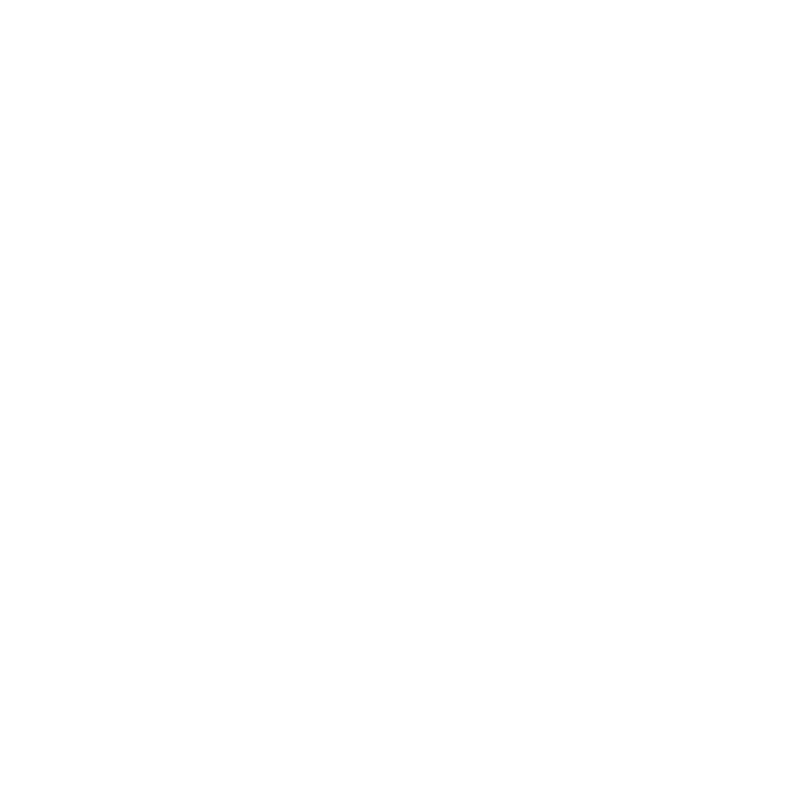

C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 35.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 28.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packag

Text(0.4, -0.5, 'CF')

In [8]:
fig2 = plt.figure(figsize=(8,8),constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=3, nrows=5, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[0, 2])

f2_ax5 = fig2.add_subplot(spec2[1, 0])
f2_ax6 = fig2.add_subplot(spec2[1, 1])
f2_ax7 = fig2.add_subplot(spec2[1, 2])

f2_ax9 = fig2.add_subplot(spec2[2, 0])
f2_ax10 = fig2.add_subplot(spec2[2, 1])
f2_ax11 = fig2.add_subplot(spec2[2, 2])

f2_ax14 = fig2.add_subplot(spec2[3, 1])
f2_ax15 = fig2.add_subplot(spec2[3, 2])


f2_ax18 = fig2.add_subplot(spec2[4,1])
f2_ax19 = fig2.add_subplot(spec2[4,2])

f2_ax20 = fig2.add_subplot(spec2[4,0])

point_size = 2.5

# Temporal
plt.sca(f2_ax1)
sns.swarmplot(y='cf_duration',x='num_bats', data=multibat_indcall,size=point_size)
plt.xlabel(''); plt.xticks([])
plt.sca(f2_ax2)
sns.swarmplot(y='tfm_duration',x='num_bats', data=multibat_indcall,size=point_size)
plt.xlabel(''); plt.xticks([])
plt.sca(f2_ax3)
sns.swarmplot(y='ifm_duration',x='num_bats', data=multibat_indcall,size=point_size)
plt.xlabel(''); plt.xticks([])

# Spectral
plt.sca(f2_ax5)
sns.swarmplot(y='cf_peak_frequency',x='num_bats', data=multibat_indcall,size=point_size)
plt.xlabel(''); plt.xticks([])
plt.sca(f2_ax6)
sns.swarmplot(y='tfm_terminal_frequency',x='num_bats', data=multibat_indcall,size=point_size)
plt.xlabel(''); plt.xticks([])
plt.ylim(80,111)
plt.sca(f2_ax7)
sns.swarmplot(y='ifm_terminal_frequency',x='num_bats', data=multibat_indcall,size=point_size)
plt.xlabel(''); plt.xticks([])
plt.ylim(80,111)
# Received level

plt.sca(f2_ax9)
sns.swarmplot(y='cf_rmsdb',x='num_bats', data=multibat_indcall,size=point_size)

plt.sca(f2_ax10)
sns.swarmplot(y='tfm_rmsdb',x='num_bats', data=multibat_indcall,size=point_size)
plt.xlabel(''); plt.xticks([])
plt.sca(f2_ax11)
sns.swarmplot(y='ifm_rmsdb',x='num_bats', data=multibat_indcall,size=point_size)
plt.xlabel(''); plt.xticks([])

# derived parameters
plt.sca(f2_ax14)
sns.swarmplot(y='tfm-cf_dbratio',x='num_bats', data=multibat_indcall,size=point_size)
plt.xlabel(''); plt.xticks([])
plt.ylim(-24,6)
plt.sca(f2_ax15)
sns.swarmplot(y='ifm-cf_dbratio',x='num_bats', data=multibat_indcall,size=point_size)
plt.xlabel(''); plt.xticks([])
plt.ylim(-24,6)

plt.sca(f2_ax18)
sns.swarmplot(y='tfm_bw',x='num_bats', data=multibat_indcall,size=point_size)
plt.text(0.4, -0.5, 'tFM', transform=f2_ax18.transAxes, fontsize=12)
plt.xlabel('')
plt.ylim(0,30)
plt.sca(f2_ax19)
sns.swarmplot(y='ifm_bw',x='num_bats', data=multibat_indcall,size=point_size)
plt.ylim(0,30)
plt.text(0.4, -0.5, 'iFM', transform=f2_ax19.transAxes, fontsize=12)
plt.xlabel('')


plt.sca(f2_ax20)
plt.axis('off')
plt.text(0.4, -0.5, 'CF', transform=f2_ax20.transAxes, fontsize=12)



The measured properties of individual calls from recordings with >2 is very similar to 2 bats - and so I'm now deciding to lump them together. 

*For a better formatted plot - please see the accompanying manuscript 'Generating summary data and plots for manuscript.ipynb'*

The only parameter that does in fact seem to be different across single and multi ($\geq$2 bats) bats is the CF duration. Let's take a look at the difference in the median values. 

<a id='combinegeq2bats'></a>
### Can we combine calls with $\geq$2 bats into a 'multi-bat' class?

Let's load the multipanel plot created in the ```./generating_summary_data_and_plots_for_manuscript.ipynb``` notebook

![image loading](./measurements_and_derivedparams_multipanel.png )

The great similarity in call parameters observed in group sizes of 2 and more allow use to combine them into a 'multi' bat class. This will help us increase the sample size in the multi-bat class, as without it each group size by itself would have a rather low sample size. 

In [9]:


ind_call = ind_call.copy()
for col in ['ifm_rms','tfm_rms','cf_rms']:
    ind_call[col+'db'] = dB(ind_call[col])

ind_call['ifm_bw'] = ind_call['cf_peak_frequency'] - ind_call['ifm_terminal_frequency']
ind_call['tfm_bw'] = ind_call['cf_peak_frequency'] - ind_call['tfm_terminal_frequency']

# scale down the measurement units so they look pretty on the graphs
for each in ['ifm_bw', 'tfm_bw', 'cf_peak_frequency', 'tfm_terminal_frequency','ifm_terminal_frequency']:
    ind_call[each] *= 0.001

ind_call['cf_duration'] *= 10**3
ind_call['tfm_duration'] *= 10**3
ind_call['ifm_duration'] *= 10**3



<a id='assignendtime'></a>
### Assigning annotation end time 

In [10]:
ind_call['annot_end_time']   = icf.get_startstoptime_from_annotation_id(ind_call['video_annot_id'], video_annotations_folder)
ind_call['annot_start_time'] = icf.get_startstoptime_from_annotation_id(ind_call['video_annot_id'], 
                                                                        video_annotations_folder, endtime=False)

In [11]:
ind_call['posix_end_time'] = ind_call['annot_end_time'].apply(icf.convert_annotation_time_to_posix)
ind_call['posix_start_time'] = ind_call['annot_start_time'].apply(icf.convert_annotation_time_to_posix)


In [12]:
# sort individual calls by their annotation start time 
ind_call = ind_call.sort_values(by ='posix_start_time').reset_index(drop=True)

In [13]:
ind_call

,Unnamed: 0,ifm_start,ifm_peak_freq_resolution,ifm_terminal_frequency,ifm_duration,ifm_peak_frequency,ifm_rms,ifm_stop,ifm_peak_amplitude,ifm_region_id,...,cf-peak_db,ifm_rmsdb,tfm_rmsdb,cf_rmsdb,ifm_bw,tfm_bw,annot_end_time,annot_start_time,posix_end_time,posix_start_time
0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-22.984276,NaN,-34.909538,-26.417414,NaN,18.196356,2018-08-16 22:24:26,2018-08-16 22:24:25,1.534451e+09,1.534451e+09
1,8,0.000100,2427.184466,99.264706,0.816,106617.647059,0.006330,0.000916,0.012207,fm1,...,-19.717825,-43.971904,-35.169376,-36.707915,9.386980,19.079493,2018-08-16 22:25:24,2018-08-16 22:25:21,1.534451e+09,1.534451e+09
2,9,0.000000,1028.806584,103.305785,1.936,105888.429752,0.017799,0.001936,0.050476,fm1,...,-29.918365,-34.992221,-36.434588,-16.518988,4.347649,4.928068,2018-08-16 22:25:47,2018-08-16 22:25:44,1.534451e+09,1.534451e+09
3,10,0.000736,1237.623762,92.039801,1.608,103855.721393,0.020311,0.002344,0.042267,fm1,...,-10.048882,-33.845518,-32.151383,-28.150393,13.361269,14.785024,2018-08-16 22:28:17,2018-08-16 22:28:16,1.534451e+09,1.534451e+09
4,11,0.000348,1173.708920,96.108491,1.696,102594.339623,0.007325,0.002044,0.019714,fm1,...,-22.596873,-42.703342,-42.676503,-33.825742,7.186083,7.822133,2018-08-16 22:28:47,2018-08-16 22:28:46,1.534451e+09,1.534451e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,227,0.000108,5813.953488,85.294118,0.340,102941.176471,0.004141,0.000448,0.008911,fm1,...,-20.543626,-47.658144,-39.412485,-38.469716,17.158879,17.445823,2018-08-20 03:30:35,2018-08-20 03:30:34,1.534729e+09,1.534729e+09
228,228,0.000368,1077.586207,86.580087,1.848,89826.839827,0.017552,0.002216,0.036652,fm1,...,-20.252266,-35.113558,-28.187474,-29.569817,15.369026,18.414004,2018-08-20 03:35:44,2018-08-20 03:35:43,1.534729e+09,1.534729e+09
229,229,0.000452,1302.083333,93.342037,1.532,95953.002611,0.016604,0.001984,0.027985,fm1,...,-26.270137,-35.595860,-25.315148,-26.400488,12.595885,18.543854,2018-08-20 03:37:58,2018-08-20 03:37:58,1.534729e+09,1.534729e+09
230,230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-29.201432,NaN,-33.618774,-32.651990,NaN,17.393090,2018-08-20 03:38:01,2018-08-20 03:38:00,1.534729e+09,1.534729e+09


In [14]:
unique_timestamps = np.sort(np.unique(ind_call['posix_end_time']))

In [15]:
first_night = ind_call[ind_call['posix_end_time']<500000+1.534*10**9]['posix_end_time']

<IPython.core.display.Javascript object>


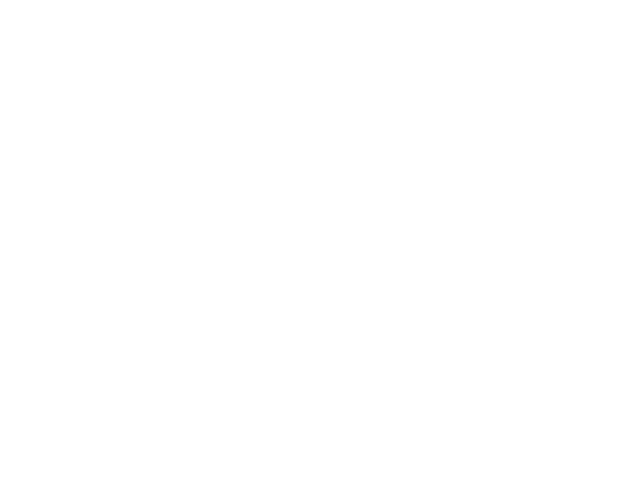

In [16]:
plt.figure()
plt.vlines(first_night, np.tile(0,first_night.size),np.tile(1,first_night.size), linewidth=0.3)

In [14]:
def calc_inter_annot_timegaps(startstop_times):
    '''
    Parameters
    ----------
    startstop_times : np.array
        Nannotsx2 np.array with posix time stamps
    Returns 
    -------
    interannot_timegaps : np.array
        Nannots-1 timegaps
    '''
    interannot_timegaps = np.zeros(startstop_times.shape[0]-1)
    for i in range (1,startstop_times.shape[0]):
        interannot_timegaps[i-1] = startstop_times[i,0]-startstop_times[i-1,1]
    return interannot_timegaps

In [15]:
raw_annot_timestamps = ind_call.loc[:,['posix_start_time','posix_end_time']].to_numpy()
interannot_timegaps_raw = calc_inter_annot_timegaps(raw_annot_timestamps)

NameError: name 'ind_call' is not defined

In [19]:
negative_timegap_indices = np.argwhere(interannot_timegaps_raw<0).flatten()
negative_timegap_indices

array([  9,  61,  63, 104, 156, 164], dtype=int64)

In [20]:
overlapped_annots_rowindices = negative_timegap_indices + 1

Some calls' annotations have weird start/stop timestamps that are either repeats or are overlapping with other annotations. 
Let me now remove these annotaitons. I'm arbitrarily choosing the second annotation in each problem pair to be the issue, and removing it. 

In [21]:
ind_call = ind_call.drop(overlapped_annots_rowindices, axis=0).reset_index(drop=True)

In [22]:
ind_call['groupsize'] = 'NA'
for i,each in ind_call.iterrows():
    if each['num_bats']>1:
        ind_call.loc[i,'groupsize'] = 'multiple'
    else:
        ind_call.loc[i,'groupsize'] = 'single'
# Sample sizes:
single, multi = ind_call[ind_call['num_bats']==1], ind_call[ind_call['num_bats']>1]
print('Single call measurements %d \n and \n Multi call measurements %d '%(single.shape[0], multi.shape[0]))
 

Single call measurements 177 
 and 
 Multi call measurements 49 


In [23]:
ind_call.to_csv('indcall_final.csv') # version with only proper timestamped annotations

<a id='indcalldeltamedian'></a>
### Estimating parameter differences between single and multi-bat calls
To see how different the single and multi-bat calls are we will now calculate the  difference ($\Delta$median) and its bootstrapped confidence itnerval between the two groups, and generate a distribution. 


In [24]:
%matplotlib notebook

In [25]:
parts = ['cf','tfm','ifm']
durn_colnames = [ each +'_duration' for each in parts]
spectral_colnames = ['cf_peak_frequency','tfm_terminal_frequency', 'ifm_terminal_frequency']
intensity_colnames = [each + '_dbrms' for each in parts]
relative_cf_intensity_colnames = ['tfm-cf_dbratio','ifm-cf_dbratio']
fm_bandwidth_colnames = ['tfm_bw', 'ifm_bw']

all_columns = durn_colnames + spectral_colnames + intensity_colnames + relative_cf_intensity_colnames + fm_bandwidth_colnames

In [26]:
def process_for_testing(param_df, colname, **kwargs):
    '''
    Parameters
    -----------
    param_df : pd.DataFrame
        With at least the columns 'groupsize' and the input colname, where the input colname 
        has the values for the measurement/category.
    resamples : int
        Number of resamples to perform for bootstrap confidence interval estimation. 
    idx : list
        With strings. Defaults to ['single','multiple']

    Returns 
    -------
    dabest._classes.Dabest
        The output of dabest.load
    '''
    kwargs['idx'] = kwargs.get('idx',['single', 'multiple'])
    singlemulti_param = param_df.pivot(values=colname,columns=['groupsize'])
    if colname != 'cf_peak_frequency':
        return dabest.load(singlemulti_param, **kwargs)
    elif colname == 'cf_peak_frequency':
        return calculate_range_difference_multipleminusother(singlemulti_param,**kwargs)
        

class calculate_range_difference_multipleminusother():
    '''
    Calculates the range difference between multiple and the other group, 
    and also generates the bootstrapped confidence interval. 
    '''
    def __init__(self, df,**kwargs):
        self.df = df
        self.kwargs = kwargs
        self.kwargs['n_samples'] = self.kwargs.get('resamples',10000)
        for each in ['resamples', 'idx']:
            self.kwargs.pop(each, None)
        self.results = pd.DataFrame(data=[])
        self.bca_interval = [np.nan, np.nan]
        
    def range_diff(self):
                
        multi = self.df['multiple'].to_numpy()
        try:
            non_multi = self.df['single'].to_numpy()
        except:
            non_multi = self.df['multiple_virtual'].to_numpy()
        
        self.bca_interval = boot.ci((non_multi, multi), 
                                    self.delta_range_calculation, **self.kwargs)
        obs_range_difference = self.delta_range_calculation(non_multi, multi)
        
        perm_pvalue = self.perform_perm_test(non_multi, multi, **self.kwargs)
        
        self.results_data = {'bca_low'   : [np.min(self.bca_interval)],
                            'bca_high'  : [np.max(self.bca_interval)],
                            'difference': [obs_range_difference],
                            'pvalue_permutation':[perm_pvalue]
                           }
        self.results = pd.DataFrame(data=self.results_data)
    
    def perform_perm_test(self, non_multi,multi,**kwargs):
        
        all_data = np.concatenate((multi, non_multi))
        shuf_range_diff = []
        
        runs = kwargs.get('resamples',10000)
        for each in range(runs):
            shuf_data = np.random.choice(all_data, all_data.size, replace=False)
            shuf_mulit, shuf_nonmulti = shuf_data[:multi.size], shuf_data[multi.size:]
            shuf_range_diff.append(self.delta_range_calculation(shuf_nonmulti, shuf_mulit))
        
        obs_rangediff = self.delta_range_calculation(non_multi, multi)
        perm_p_value = stats.percentileofscore(shuf_range_diff,obs_rangediff)*0.01 
        return perm_p_value
    
    def delta_range_calculation(self, A,B):
        '''
        Calculates range(B)-range(A)
        '''
        range_A = np.nanmax(A)-np.nanmin(A)
        range_B = np.nanmax(B)-np.nanmin(B)
        return range_B-range_A
    
        
def parse_result_output(dd_results):
    '''
    Parses the results attribute of a dabest.median_diff run and checks the following
    
    Parameters
    ----------
    dd_results : pd.DataFrame
    
    Returns
    -------
    
    
    '''
    parsed_output = {}
    # does the bca_low,bca_high have zero in it
    parsed_output['ci_has_zero'] = np.logical_and(dd_results['bca_low']<=0, dd_results['bca_high']>=0)

    # if not is the interval greater or less than 0?
    
    parsed_output['ci_above_zero'] = np.logical_and(dd_results['bca_low']>0, dd_results['bca_high']>0)
    parsed_output['ci_below_zero'] = np.logical_and(dd_results['bca_low']<0, dd_results['bca_high']<0)
    parsed_output['perm_pvalue'] = dd_results['pvalue_permutation']
    parsed_output['difference'] = dd_results['difference']
    parsed_output['perm_pvalue_signif'] = parsed_output['perm_pvalue']<0.05
    parsed_output['bca_low'] = dd_results['bca_low']
    parsed_output['bca_high'] = dd_results['bca_high']
    
    return pd.DataFrame(data=parsed_output)

def produce_parsed_outputs_for_indcall_datafolds(datafold, colnames,**kwargs):
    '''
    '''
    resample_num = kwargs.get('resamples',10000)
    test_output = {}
    for eachcol in colnames:
        param_df = datafold.loc[:,[eachcol,'groupsize']]
        if eachcol != 'cf_peak_frequency':
            dd = process_for_testing(param_df, eachcol,resamples=resample_num, **kwargs).median_diff
        elif eachcol == 'cf_peak_frequency':
            dd = process_for_testing(param_df, eachcol,resamples=resample_num, **kwargs)
            dd.range_diff()
        
        test_output[eachcol] = dd

        
    parsed_outputs = {}
    for each in tqdm.tqdm(colnames):
        parsed_outputs[each] = parse_result_output(test_output[each].results)
    outputs = []
    for msmt, parsedoutput in parsed_outputs.items():
        parsedoutput['measurement'] = msmt
        outputs.append(parsedoutput)
    comparisons = pd.concat(outputs)
    return comparisons


In [27]:
import scipy.stats as stats

In [28]:
alldata_comparisons = produce_parsed_outputs_for_indcall_datafolds(ind_call, all_columns)
alldata_comparisons

C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\ipykernel_launcher.py:49: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:29<00:00,  2.26s/it]


,ci_has_zero,ci_above_zero,ci_below_zero,perm_pvalue,difference,perm_pvalue_signif,bca_low,bca_high,measurement
0,False,False,True,0.0026,-2.948000,True,-4.124000,-0.938000,cf_duration
0,True,False,False,0.1596,0.140000,False,-0.208000,0.368000,tfm_duration
0,True,False,False,0.7050,-0.038000,False,-0.220000,0.238000,ifm_duration
0,True,False,False,0.1755,-1.001560,False,-3.126679,0.703161,cf_peak_frequency
0,True,False,False,0.2904,-1.031604,False,-3.042035,0.611956,tfm_terminal_frequency
0,True,False,False,0.2438,1.068376,False,-2.453450,2.887698,ifm_terminal_frequency
0,True,False,False,0.2000,-1.476519,False,-3.491195,0.036009,cf_dbrms
0,True,False,False,0.0092,-3.153248,True,-5.047240,0.001948,tfm_dbrms
0,True,False,False,0.3178,-1.663614,False,-4.173426,1.235931,ifm_dbrms
0,True,False,False,0.1606,-1.075383,False,-1.846299,0.691911,tfm-cf_dbratio


In [29]:
alldata_comparisons.to_csv('alldata_indcall_ci.csv')

What we can see by including all the median differences of multi-single are that only two parameters seem to show median differences whose intervals do not overlap with zero - CF duration and CF received level. Median CF duration seems to reduce by 3ms in multi bat groups. The median CF dB rms seems to decrease by -1.4 dB in multi bat groups.

#### CF-peak frequency *range difference* is reported
The reported 'difference' for ```cf_peak_frequency``` is the difference in range (range(multiple)-range(single)). All other reported differences are median differences (median(multiple)-median(single)).

The bias corrected and accelarated bootstrap confidence intervals are used, it is suggested to be the best and most general method to get confidence intervals (Puth,Neuhäuser,Ruxton 2015)

#### References:
    * Puth, M. T., Neuhäuser, M., & Ruxton, G. D. (2015). On the variety of methods for calculating confidence intervals by bootstrapping. Journal of Animal Ecology, 84(4), 892-897.

<a id='temporalrarefaction'></a>
### Estimating difference between single and multi - with interval separated data folds.

All the calls in the dataset are likely to be temporally correlated as it may be the same individuals flying in and out of the caves. This is based on our observations of short bursts of in and out flights over the scale of a few seconds to a minute. Here let us attempt to see how robust our results are when we begin to include only samples that are at least X seconds apart from each other. 

The main concern we attempt to address here is basically that by using 'all' the annotation matched audio, we are not including the whole range of variation that is actually present in the data. By spreading the data points across time, we will be able to assess a larger variety of bats and situations - and thus assess differences in call properties better.

In [30]:
startstoptimes_clean = ind_call.loc[:,['posix_start_time','posix_end_time']].to_numpy()
interannot_separation = calc_inter_annot_timegaps(startstoptimes_clean)

<IPython.core.display.Javascript object>


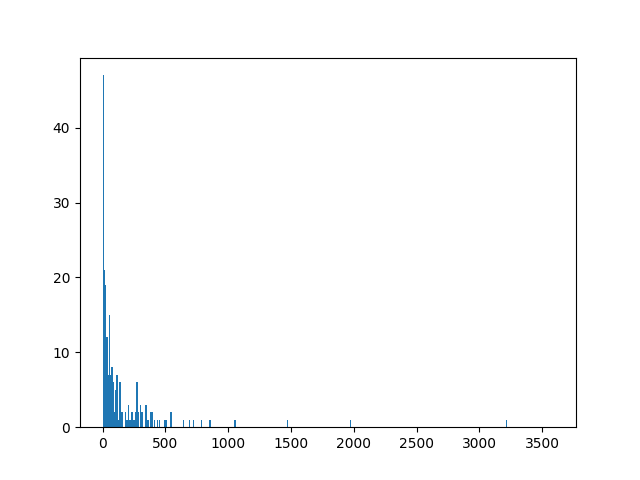

In [31]:

plt.figure()
plt.hist(interannot_separation, bins=np.arange(0,3600,10));

### Inter-annotation intervals - all annotations
Let's take a look at the distribution of inter-annotation intervals when *all* individual call annotations are considered. 

In [34]:
pctiles = [0,2.5,25,50,75,97.5,100]
interannot_distbn = np.percentile(interannot_separation, pctiles)/60.0

interannot_df = pd.DataFrame(data={'percentile':pctiles, 'minutes':interannot_distbn})

print(f'The distribution of inter-annotation intervals is \n \n {interannot_df} ')

NameError: name 'interannot_separation' is not defined

### Reducing pseudo-replication by splitting the dataset into 'clustered' and 'isolated' subsets
Pseudo-replication in our dataset is likely to be caused by the same individuals showing high-activity over short periods of time, eg. flying in and out over the span of a few seconds to a minute. The idea is to create two subsets of the data - the 'clustered' and 'isolated' subsets. The 'clustered' subset has all data points which are are <=X minutes of another. The 'isolated' subset has all data points that are >X minutes of another data point. 

If the trends observed are consistent across the clustered and isolated subsets, then we are closer to reducing the effect pseudo-replication may have in our final interpretation of the results. 

In [33]:
startstop_times = np.column_stack((ind_call['posix_start_time'], ind_call['posix_end_time']))


In [34]:
clustered_rows, isolated_rows = annots_by_time.split_into_clustered_and_nonclustered(startstop_times, 60)
clustered_datafold = ind_call.loc[clustered_rows,:].reset_index(drop=True)
isolated_datafold = ind_call.loc[isolated_rows,:].reset_index(drop=True)


In [35]:
clustered_datafold.to_csv('clustered_indcall.csv')
isolated_datafold.to_csv('isolated_indcall.csv')

In [36]:
print(clustered_datafold.shape, isolated_datafold.shape)

(168, 53) (58, 53)


In [37]:
for each,annot_group in tqdm.tqdm(zip([clustered_datafold, isolated_datafold], ['clustered','isolated'])):
    parsed_out = produce_parsed_outputs_for_indcall_datafolds(each, all_columns) 
    parsed_out['interval'] = annot_group
    parsed_out.to_csv(annot_group+'_subset_clusteringbased_bootci.csv')


0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.21s/it]
1it [00:30, 30.67s/it]C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: All-NaN slice encountered
C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\ipykernel_launcher.py:49: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.

 15%|████████████▊                                                                      | 2/13 [00:04<00:24,  2.22s/it]C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\dabest\_classes.py:792: UserWarning: The lo

In [38]:
parsed_out

,ci_has_zero,ci_above_zero,ci_below_zero,perm_pvalue,difference,perm_pvalue_signif,bca_low,bca_high,measurement,interval
0,False,False,True,0.2440,-3.928000,False,-7.496000,-0.516000,cf_duration,isolated
0,True,False,False,0.8792,0.048000,False,-0.360000,1.644000,tfm_duration,isolated
0,False,False,True,0.8166,-0.100000,False,-0.100000,-0.100000,ifm_duration,isolated
0,False,False,False,0.0000,-4.084191,True,NaN,NaN,cf_peak_frequency,isolated
0,False,False,True,0.1580,-3.842760,False,-6.316099,-0.573688,tfm_terminal_frequency,isolated
0,False,False,True,0.3200,-3.462222,False,-3.462222,-3.462222,ifm_terminal_frequency,isolated
0,True,False,False,0.8220,-0.775353,False,-8.233218,4.365656,cf_dbrms,isolated
0,True,False,False,0.5868,-1.941201,False,-11.764490,7.671434,tfm_dbrms,isolated
0,True,False,False,0.3246,-3.208035,False,-11.960283,3.886259,ifm_dbrms,isolated
0,True,False,False,0.8192,-0.550388,False,-3.672521,5.974616,tfm-cf_dbratio,isolated


In [39]:
parsed_out = produce_parsed_outputs_for_indcall_datafolds(clustered_datafold, all_columns) 
parsed_out

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:26<00:00,  2.06s/it]


,ci_has_zero,ci_above_zero,ci_below_zero,perm_pvalue,difference,perm_pvalue_signif,bca_low,bca_high,measurement
0,False,False,True,0.0070,-2.706000,True,-3.932000,-0.396000,cf_duration
0,True,False,False,0.0876,0.174000,False,-0.174000,0.398000,tfm_duration
0,True,False,False,0.6942,-0.062000,False,-0.308000,0.200000,ifm_duration
0,False,False,True,0.0021,-2.317439,True,-3.507238,-0.825832,cf_peak_frequency
0,True,False,False,0.8906,-0.154506,False,-2.177812,2.255290,tfm_terminal_frequency
0,True,False,False,0.4636,0.781812,False,-2.517277,2.542503,ifm_terminal_frequency
0,True,False,False,0.2240,-1.360965,False,-3.446203,0.511947,cf_dbrms
0,True,False,False,0.0746,-2.224033,False,-4.268171,1.181431,tfm_dbrms
0,True,False,False,0.9370,-0.000509,False,-3.185962,3.134440,ifm_dbrms
0,True,False,False,0.1556,-1.240479,False,-2.119121,0.428951,tfm-cf_dbratio


Let's choose two inter-annotation intervals - one which is around the median (1 min) and the other which is *out* of the 95%ile interval (15min).  We can expect that the 15minut interval is likely to have much more variation and less pseudo-replication in its measurements as bat activity seems to be clustered at lower time scales. 

<a id='wholeaudioanalysis'></a>
## Window analysis 

In [5]:
# let's load the spit-measure data from the whole audio analysis 
obs_splitmeasure_raw = pd.read_csv('../annotation_audio_analysis/analysis/obs_nonsilent_measurements_20dBthreshold_wcentdomfreqs.csv')
virt_splitmeasure = pd.read_csv('../annotation_audio_analysis/analysis/virt_nonsilent_measurement_20dBthreshold_wcentdomfreqs.csv')

In [6]:
by_numbatsfilename  = obs_splitmeasure_raw.groupby(['num_bats','file_name'])

In [7]:
numbats = [ gpsize[0] for gpsize, _ in by_numbatsfilename]
np.unique(numbats, return_counts=True)

(array([1, 2, 3, 4], dtype=int64), array([236,  71,  18,   6], dtype=int64))

We see the same kind of sample size skew towards single bats. To keep comparability with the individual call analysis - let us combine all $\geq$2 bat cases into one 'multi-bat' group.

In [8]:
grouplabel  = {1:'single',
               2:'multiple',
               3:'multiple',
               4:'multiple'}

obs_splitmeasure_raw['groupsize'] = obs_splitmeasure_raw.apply(lambda X: grouplabel[X['num_bats']], axis=1)
virt_splitmeasure['groupsize'] = 'multiple_virtual'

### Time gap between annotations in window analysis :


In [9]:
obs_splitmeasure_raw

,Unnamed: 0,Unnamed: 0.1,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,groupsize
0,0,0,0.022077,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
1,1,1,0.062134,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
2,2,3,90332.031250,0,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
3,3,4,89843.750000,0,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
4,4,5,0.031445,1,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,1_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
...,...,...,...,...,...,...,...,...,...,...
15962,15962,17910,105480.000000,3,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0300-040...,3_matching_annotaudio_Aditya_2018-08-20_0300-0...,Aditya_2018-08-20_0300-0400_90,1,single
15963,15963,17917,105960.000000,4,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0300-040...,4_matching_annotaudio_Aditya_2018-08-20_0300-0...,Aditya_2018-08-20_0300-0400_90,1,single
15964,15964,17922,106120.000000,5,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0300-040...,5_matching_annotaudio_Aditya_2018-08-20_0300-0...,Aditya_2018-08-20_0300-0400_90,1,single
15965,15965,17927,106320.000000,6,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0300-040...,6_matching_annotaudio_Aditya_2018-08-20_0300-0...,Aditya_2018-08-20_0300-0400_90,1,single


In [10]:
unique_video_annot_ids = pd.DataFrame(data={'video_annot_id':np.unique(obs_splitmeasure_raw['video_annot_id'])}).reset_index(drop=True)

# assign the annotation start/end time and posix timestamps to each audio file
unique_video_annot_ids['annot_end_time']   = icf.get_startstoptime_from_annotation_id(unique_video_annot_ids['video_annot_id'], video_annotations_folder)
unique_video_annot_ids['annot_start_time'] = icf.get_startstoptime_from_annotation_id(unique_video_annot_ids['video_annot_id'], video_annotations_folder,
                                                                                      endtime=False)
unique_video_annot_ids['posix_end_time'] = unique_video_annot_ids['annot_end_time'].apply(icf.convert_annotation_time_to_posix)                                                                     
unique_video_annot_ids['posix_start_time'] = unique_video_annot_ids['annot_start_time'].apply(icf.convert_annotation_time_to_posix)


In [11]:
unique_video_annot_ids = unique_video_annot_ids.sort_values(by='posix_start_time').reset_index(drop=True)

In [16]:
annotaudio_timestamps = unique_video_annot_ids.loc[:,['posix_start_time','posix_end_time']].to_numpy()
interannot_timegaps_raw_audio = calc_inter_annot_timegaps(annotaudio_timestamps)

In [19]:
np.percentile(interannot_timegaps_raw_audio, pctiles)/60.0


NameError: name 'pctiles' is not defined

In [20]:
neg_timegaps_annotaudio = np.argwhere(interannot_timegaps_raw_audio<0).flatten()
print(neg_timegaps_annotaudio)

[  9  11  80  82  87  91 140 226 234]


In [21]:
neg_annot_secns = []
relevant_columns = ['posix_start_time','posix_end_time','video_annot_id','annot_start_time','annot_end_time']
for each in neg_timegaps_annotaudio:
    neg_annot_secns.append(unique_video_annot_ids.loc[each:each+1,relevant_columns])
pd.concat(neg_annot_secns)

,posix_start_time,posix_end_time,video_annot_id,annot_start_time,annot_end_time
9,1.534452e+09,1.534452e+09,Aditya_2018-08-16_21502300_37,2018-08-16 22:37:39,2018-08-16 22:37:46
10,1.534452e+09,1.534452e+09,Aditya_2018-08-16_21502300_36,2018-08-16 22:37:39,2018-08-16 22:37:46
11,1.534452e+09,1.534452e+09,Aditya_2018-08-16_21502300_39,2018-08-16 22:37:47,2018-08-16 22:37:50
12,1.534452e+09,1.534452e+09,Aditya_2018-08-16_21502300_40,2018-08-16 22:37:48,2018-08-16 22:37:52
80,1.534456e+09,1.534456e+09,Aditya_2018-08-16_2324_207,2018-08-16 23:45:12,2018-08-16 23:45:13
81,1.534456e+09,1.534456e+09,Aditya_2018-08-16_2324_208,2018-08-16 23:45:12,2018-08-16 23:45:13
82,1.534456e+09,1.534456e+09,Aditya_2018-08-16_2324_211,2018-08-16 23:45:18,2018-08-16 23:45:19
83,1.534456e+09,1.534456e+09,Aditya_2018-08-16_2324_212,2018-08-16 23:45:18,2018-08-16 23:45:19
87,1.534456e+09,1.534456e+09,Aditya_2018-08-16_2324_219,2018-08-16 23:45:41,2018-08-16 23:45:42
88,1.534456e+09,1.534456e+09,Aditya_2018-08-16_2324_220,2018-08-16 23:45:41,2018-08-16 23:45:41


Here too, there are some annotations that overlap with a previous one, or have the same same timestamps. I'm going to arbitrarily remove the later annotation. 

In [22]:
annotinds_to_remove = neg_timegaps_annotaudio + 1 
annotations_to_remove = unique_video_annot_ids.loc[annotinds_to_remove,'video_annot_id']

In [23]:
annotinds_to_remove

array([ 10,  12,  81,  83,  88,  92, 141, 227, 235], dtype=int64)

In [24]:
unique_video_annot_ids.loc[annotinds_to_remove,:]

,video_annot_id,annot_end_time,annot_start_time,posix_end_time,posix_start_time
10,Aditya_2018-08-16_21502300_36,2018-08-16 22:37:46,2018-08-16 22:37:39,1.534452e+09,1.534452e+09
12,Aditya_2018-08-16_21502300_40,2018-08-16 22:37:52,2018-08-16 22:37:48,1.534452e+09,1.534452e+09
81,Aditya_2018-08-16_2324_208,2018-08-16 23:45:13,2018-08-16 23:45:12,1.534456e+09,1.534456e+09
83,Aditya_2018-08-16_2324_212,2018-08-16 23:45:19,2018-08-16 23:45:18,1.534456e+09,1.534456e+09
88,Aditya_2018-08-16_2324_220,2018-08-16 23:45:41,2018-08-16 23:45:41,1.534456e+09,1.534456e+09
92,Aditya_2018-08-16_2324_228,2018-08-16 23:45:52,2018-08-16 23:45:50,1.534456e+09,1.534456e+09
141,Aditya_2018-08-17_12_28,2018-08-17 01:19:58,2018-08-17 01:19:57,1.534462e+09,1.534462e+09
227,Aditya_2018-08-17_34_65,2018-08-17 03:18:29,2018-08-17 03:18:28,1.534469e+09,1.534469e+09
235,Aditya_2018-08-17_34_132,2018-08-17 03:39:25,2018-08-17 03:39:20,1.534470e+09,1.534470e+09


In [25]:
annotids_wo_overlaps = unique_video_annot_ids.drop(annotinds_to_remove, axis=0).reset_index(drop=True)

In [26]:
annotaudio_timestamps_x = annotids_wo_overlaps.loc[:,['posix_start_time','posix_end_time']].to_numpy()
interannot_timegaps_raw_audio_x = calc_inter_annot_timegaps(annotaudio_timestamps_x)

In [27]:
np.argwhere(interannot_timegaps_raw_audio_x<0)

array([[83]], dtype=int64)

In [28]:
annotids_wo_overlaps.loc[82:84,:]

,video_annot_id,annot_end_time,annot_start_time,posix_end_time,posix_start_time
82,Aditya_2018-08-16_2324_218,2018-08-16 23:45:41,2018-08-16 23:45:41,1.534456e+09,1.534456e+09
83,Aditya_2018-08-16_2324_219,2018-08-16 23:45:42,2018-08-16 23:45:41,1.534456e+09,1.534456e+09
84,Aditya_2018-08-16_2324_221,2018-08-16 23:45:42,2018-08-16 23:45:41,1.534456e+09,1.534456e+09


Here we can see that annotations *Aditya_2018-08-16_2324_219* *Aditya_2018-08-16_2324_221* have the start and end times inverted and with the same values. Let's therefore remove both of these annotations from the list of acceptable annotations. 

In [29]:
rows_to_remove = np.argwhere(interannot_timegaps_raw_audio_x<0).flatten().tolist()
rows_to_remove.append(rows_to_remove[0]+1)

In [30]:
rows_to_remove

[83, 84]

In [31]:
annotids_wo_overlaps = annotids_wo_overlaps.drop(rows_to_remove,axis=0).reset_index(drop=True)

In [32]:
annotaudio_timestamps = annotids_wo_overlaps.loc[:,['posix_start_time','posix_end_time']].to_numpy()
interannot_timegaps_raw_audio = calc_inter_annot_timegaps(annotaudio_timestamps)

In [33]:
annotaudio_interannot_distbn = np.percentile(interannot_timegaps_raw_audio, pctiles)/60


annotaudio_interannot_df = pd.DataFrame(data={'percentile':pctiles, 'minutes':annotaudio_interannot_distbn})

print(f'The distribution of inter-annotation intervals in the window analysis is \n \n {annotaudio_interannot_df} ')

NameError: name 'pctiles' is not defined

In [63]:
pctiles

[0, 2.5, 25, 50, 75, 97.5, 100]

In [35]:
# after cleaning and only including annotations with sensible timestamps
obs_splitmeasure = obs_splitmeasure_raw[obs_splitmeasure_raw['video_annot_id'].isin(annotids_wo_overlaps['video_annot_id'])].reset_index(drop=True)

We can see that the median inter-annotation interval (0.6min) for the window analysis is of the same order of magnitude as in the individual call analysis (0.8min). We can thus take a common 1 minute interval as the clustering threshold.  


In [39]:
obs_splitmeasure.head()


,Unnamed: 0,Unnamed: 0.1,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,groupsize
0,0,0,0.022077,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
1,1,1,0.062134,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
2,2,3,90332.031250,0,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
3,3,4,89843.750000,0,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
4,4,5,0.031445,1,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,1_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single


In [40]:
unique_video_annot_ids

,video_annot_id,annot_end_time,annot_start_time,posix_end_time,posix_start_time
0,Aditya_2018-08-16_21502300_18,2018-08-16 22:24:26,2018-08-16 22:24:25,1.534451e+09,1.534451e+09
1,Aditya_2018-08-16_21502300_20,2018-08-16 22:25:24,2018-08-16 22:25:21,1.534451e+09,1.534451e+09
2,Aditya_2018-08-16_21502300_22,2018-08-16 22:25:47,2018-08-16 22:25:44,1.534451e+09,1.534451e+09
3,Aditya_2018-08-16_21502300_24,2018-08-16 22:28:17,2018-08-16 22:28:16,1.534451e+09,1.534451e+09
4,Aditya_2018-08-16_21502300_25,2018-08-16 22:28:47,2018-08-16 22:28:46,1.534451e+09,1.534451e+09
...,...,...,...,...,...
326,Aditya_2018-08-20_0300-0400_35,2018-08-20 03:22:14,2018-08-20 03:22:13,1.534728e+09,1.534728e+09
327,Aditya_2018-08-20_0300-0400_58,2018-08-20 03:28:44,2018-08-20 03:28:40,1.534729e+09,1.534729e+09
328,Aditya_2018-08-20_0300-0400_85,2018-08-20 03:35:44,2018-08-20 03:35:43,1.534729e+09,1.534729e+09
329,Aditya_2018-08-20_0300-0400_90,2018-08-20 03:37:58,2018-08-20 03:37:58,1.534729e+09,1.534729e+09


In [44]:
unique_video_annot_ids['posix_middle'] = (unique_video_annot_ids['posix_start_time']+unique_video_annot_ids['posix_end_time'])/2.0

In [45]:
unique_video_annot_ids

,video_annot_id,annot_end_time,annot_start_time,posix_end_time,posix_start_time,posix_middle
0,Aditya_2018-08-16_21502300_18,2018-08-16 22:24:26,2018-08-16 22:24:25,1.534451e+09,1.534451e+09,1.534451e+09
1,Aditya_2018-08-16_21502300_20,2018-08-16 22:25:24,2018-08-16 22:25:21,1.534451e+09,1.534451e+09,1.534451e+09
2,Aditya_2018-08-16_21502300_22,2018-08-16 22:25:47,2018-08-16 22:25:44,1.534451e+09,1.534451e+09,1.534451e+09
3,Aditya_2018-08-16_21502300_24,2018-08-16 22:28:17,2018-08-16 22:28:16,1.534451e+09,1.534451e+09,1.534451e+09
4,Aditya_2018-08-16_21502300_25,2018-08-16 22:28:47,2018-08-16 22:28:46,1.534451e+09,1.534451e+09,1.534451e+09
...,...,...,...,...,...,...
326,Aditya_2018-08-20_0300-0400_35,2018-08-20 03:22:14,2018-08-20 03:22:13,1.534728e+09,1.534728e+09,1.534728e+09
327,Aditya_2018-08-20_0300-0400_58,2018-08-20 03:28:44,2018-08-20 03:28:40,1.534729e+09,1.534729e+09,1.534729e+09
328,Aditya_2018-08-20_0300-0400_85,2018-08-20 03:35:44,2018-08-20 03:35:43,1.534729e+09,1.534729e+09,1.534729e+09
329,Aditya_2018-08-20_0300-0400_90,2018-08-20 03:37:58,2018-08-20 03:37:58,1.534729e+09,1.534729e+09,1.534729e+09


In [79]:
def assign_timestamp(df, timestamp_df):
    df_annot = timestamp_df[timestamp_df['video_annot_id']==np.unique(df['video_annot_id'])[0]]
    if df_annot.shape[0]>0:
        df = df.assign(posix_timestamp=np.tile(df_annot['posix_middle'], df.shape[0]))
    else:
        df = df.assign(posix_timestamp=np.tile(df_annot['posix_middle'], np.nan))
    return df

In [80]:
# assign a time-stamp to the each row in the datset
obs_w_timestamp = obs_splitmeasure.groupby('video_annot_id').apply(assign_timestamp, unique_video_annot_ids)

In [81]:
obs_w_timestamp


Unnamed: 0  Unnamed: 0.1          value  \
video_annot_id                                                                  
Aditya_2018-08-16_21502300_100 0               0             0       0.022077   
                               1               1             1       0.062134   
                               2               2             3   90332.031250   
                               3               3             4   89843.750000   
                               4               4             5       0.031445   
...                                          ...           ...            ...   
Aditya_2018-08-20_0300-0400_91 11554       12184         17933       0.044647   
                               11555       12185         17935   87402.343750   
                               11556       12186         17936   85449.218750   
                               11557       12187         17937   89843.750000   
                               15115       15966         17934  105200.000000   

                                      segment_number           measurement  \
video_annot_id                                                               
Aditya_2018-08-16_21502300_100 0                   0                   rms   
                               1                   0        peak_amplitude   
                               2                   0     fm_terminal_freqs   
                               3                   0     fm_terminal_freqs   
                               4                   1                   rms   
...                                              ...                   ...   
Aditya_2018-08-20_0300-0400_91 11554               3        peak_amplitude   
                               11555               3     fm_terminal_freqs   
                               11556               3     fm_terminal_freqs   
                               11557               3     fm_terminal_freqs   
                               15115               3  dominant_frequencies   

                                                                              file_name  \
video_annot_id                                                                            
Aditya_2018-08-16_21502300_100 0      matching_annotaudio_Aditya_2018-08-16_21502300...   
                               1      matching_annotaudio_Aditya_2018-08-16_21502300...   
                               2      matching_annotaudio_Aditya_2018-08-16_21502300...   
                               3      matching_annotaudio_Aditya_2018-08-16_21502300...   
                               4      matching_annotaudio_Aditya_2018-08-16_21502300...   
...                                                                                 ...   
Aditya_2018-08-20_0300-0400_91 11554  matching_annotaudio_Aditya_2018-08-20_0300-040...   
                               11555  matching_annotaudio_Aditya_2018-08-20_0300-040...   
                               11556  matching_annotaudio_Aditya_2018-08-20_0300-040...   
                               11557  matching_annotaudio_Aditya_2018-08-20_0300-040...   
                               15115  matching_annotaudio_Aditya_2018-08-20_0300-040...   

                                                                       unique_window_id  \
video_annot_id                                                                            
Aditya_2018-08-16_21502300_100 0      0_matching_annotaudio_Aditya_2018-08-16_215023...   
                               1      0_matching_annotaudio_Aditya_2018-08-16_215023...   
                               2      0_matching_annotaudio_Aditya_2018-08-16_215023...   
                               3      0_matching_annotaudio_Aditya_2018-08-16_215023...   
                               4      1_matching_annotaudio_Aditya_2018-08-16_215023...   
...                                                                                 ...   
Aditya_2018-08-20_0300-0400_91 11554  3_matching_annotaud

In [65]:
obs_splitmeasure.to_csv('obs_splitmeasure.csv')

In [83]:
obs_w_timestamp.to_csv('obs_splitmeasure_wtimestamp.csv')

### Generating clustered and isolated subsets. 
Now let us group all annotations into the 'clustered' or 'isolated' subsets. 

In [66]:
window_analysis_annots_posix_times = np.column_stack(annotids_wo_overlaps[each] for each in ['posix_start_time','posix_end_time'])
clustered_rows, isolated_rows = annots_by_time.split_into_clustered_and_nonclustered(window_analysis_annots_posix_times, 60)
windowanalysis_clustered_datafold = annotids_wo_overlaps.loc[clustered_rows,:].reset_index(drop=True)
windowanalysis_isolated_datafold = annotids_wo_overlaps.loc[isolated_rows,:].reset_index(drop=True)


C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


<a id='dominantfreqs'></a>

### Comparing dominant frequencies 

In [67]:
obs_domfreqs = obs_splitmeasure[obs_splitmeasure['measurement']=='dominant_frequencies']
obs_domfreqs['value'] *= 0.001 # convert to kHz
virt_domfreqs = virt_splitmeasure[virt_splitmeasure['measurement']=='dominant_frequencies']
virt_domfreqs['value'] *= 0.001 

C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


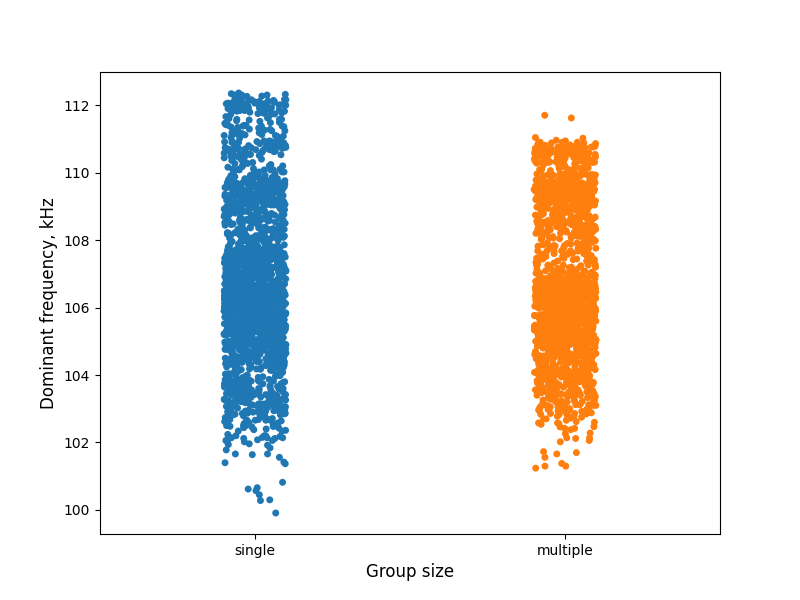

C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Group size')

In [68]:
plt.figure(figsize=(8,6))
sns.stripplot('groupsize','value',data=obs_domfreqs)
plt.ylabel('Dominant frequency, kHz', fontsize=12)
plt.xlabel('Group size', fontsize=12)

There're some dominant frequencies which don't come from the CF components. This is because in some calls, the FM components are stronger than the CF components. Let's filter out all dominant frequencies below 100 kHz.

In [69]:
obs_domfreqs  = obs_domfreqs[obs_domfreqs['value']>=100]
virt_domfreqs = virt_domfreqs[virt_domfreqs['value']>=100]

<IPython.core.display.Javascript object>


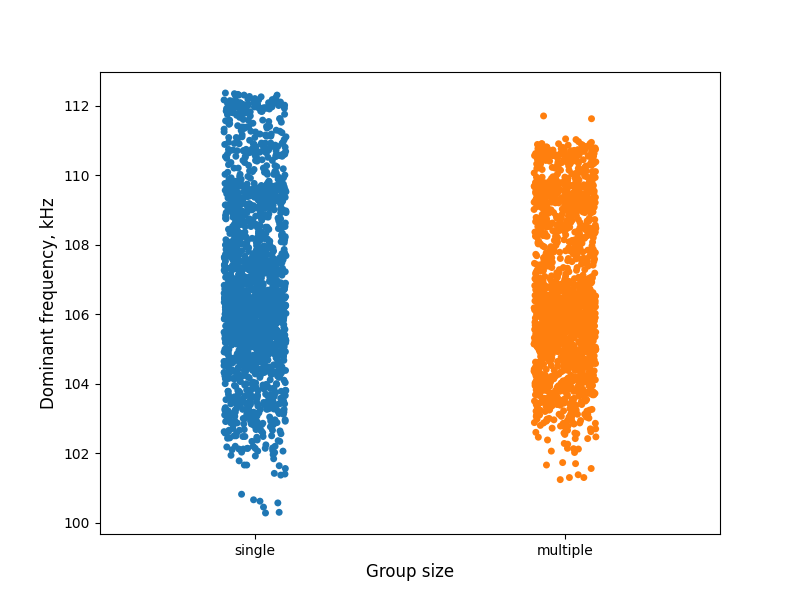

C:\Users\tbeleyur\anaconda3\envs\mhbc\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Group size')

In [70]:
plt.figure(figsize=(8,6))
sns.stripplot('groupsize','value',data=obs_domfreqs)
plt.ylabel('Dominant frequency, kHz', fontsize=12)
plt.xlabel('Group size', fontsize=12)

### Do bats try to separate or converge in their CF frequencies?

We will answer this by looking at the observed differences between the highest and lower dominant frequencies (min-max range) across windows and across recordings. 

Each audio recording is a snapshot of one set of encounters - and thus is the unit of analysis. We will perform two analyses:

1. Recording-level  dominant frequency difference: Bats may respond to each other over the course of a whole audio recording. To assess this, we quantify the min-max range between dominant frequencies across all windows in an audio file. 

1. Window-level dominant frequency difference: Bats may respond to each other's calls rapidly over the course of a few milliseconds. To quantify this we choose the min-max range between dominant frequencies observed in a window of an audio file. 

Of course there may be cases where the largest file difference is the same as the window-level difference (eg. when the largest difference occurs only in one window of the file, or when only one window in a file is non-silent). This is an attempt at analysis the difference at two temporal levels, but the analyses do not happen at completely independent levels!

#### Largest recording level dominant frequency differences:


In [71]:
def extract_largest_interwindow_difference(df):
    '''
    Outputs the largest difference between measurements across multiple segments in a file. 
    The input datframe is expected to contain measurements from multiple segments of one file only. 
    
    Parameters
    ----------
    df : pd.DataFrame 
        With compulsory columns: value, measurement, file_name
    Return
    ------
    rec_level_range : pd.DataFrame
        With columns : file_value_range, measurement, file_name, num_bats, groupsize
        
    Notes
    -----
    If a file only has one segment and there is only one measured value - a np.nan 
    is returned in the 'file_value_range'
    '''
    if len(df['value'])>1:
        range_value = np.nanmax(df['value']) - np.nanmin(df['value'])
    else: 
        range_value = np.nan
    rec_level_range = pd.DataFrame(data={'file_value_range': [range_value]})

    for each in ['measurement','file_name','num_bats','groupsize']:
        rec_level_range.loc[:,each] = df.loc[df.index[0],each]
    return rec_level_range



In [72]:
obsdomfreq_byfilename = obs_domfreqs.groupby(['file_name'])
virtdomfreq_by_filename = virt_domfreqs.groupby(['file_name'])

In [73]:
obs_reclevel_domfreq_range = obsdomfreq_byfilename.apply(extract_largest_interwindow_difference)
virt_reclevel_domfreq_range = virtdomfreq_by_filename.apply(extract_largest_interwindow_difference)
virt_reclevel_domfreq_range['groupsize'] = 'multiple_virtual'

In [74]:
obsvirt_reclevel_domfreq_range = pd.concat((obs_reclevel_domfreq_range, virt_reclevel_domfreq_range))

<IPython.core.display.Javascript object>


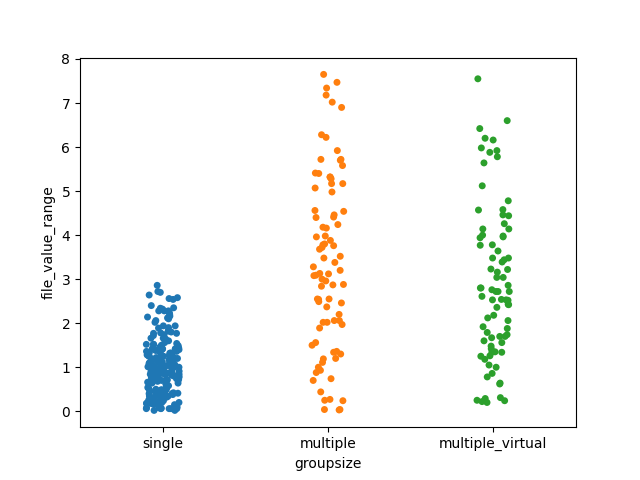

<AxesSubplot:xlabel='groupsize', ylabel='file_value_range'>

In [75]:
plt.figure()
sns.stripplot(x='groupsize',y='file_value_range',data=obsvirt_reclevel_domfreq_range)

As expected, the overall across-file difference in dominant frequencies is lower than that seen in observed and virtual multi-bat recordings. 

In [75]:
np.nanpercentile(obsvirt_reclevel_domfreq_range.groupby('groupsize').get_group('single')['file_value_range'],
                [0,50,100])

array([0.02, 1.  , 2.86])

In [76]:
obsvirt_reclevel_domfreq_range.to_csv('obsvirt_domfreq_range.csv')



### The origin of the variation in single bat dominant frequencies:
The variation in dominant frequencies has two sources:
    1. The Doppler shift compensation of the bat itself.
    1. The Doppler shift recorded at the mic as the bat flies past it. 
The Doppler shift compensation of the bat varies according to whether it changes its own flight speed from the start to slowing down as it approaches the roosting site. 

The Doppler shift recorded at the mic initially increases as the bat flies closing to the mic, and then decreases as it moves past the mic. 

Let us calculate the approximate expected shifts and check if the match what we see. 

![](doppler_shift_schematic.png)

The overall difference expected is the difference between $F_{rec}$ at the starting velocity and $F_{rec}$ at the end velocity. 

The start relative flight angle is set at 45 degrees, and the end relative flight angle is set at 135  degrees. 

In [76]:
def dopp_factor(v):
    return (330+v)/(330-v)

def non_straight_dopp_shift_at_mic(fe,v,angle):
    non_straight_factor = 330/(330-v*np.cos(angle))
    return fe*non_straight_factor
    

def calc_frec_difference(Fo, vstart,vend):
    fe_start = Fo/dopp_factor(vstart)
    frec_start = non_straight_dopp_shift_at_mic(fe_start, vstart,np.pi/4)
    
    fe_end = Fo/dopp_factor(vend)
    frec_end = non_straight_dopp_shift_at_mic(fe_end, vend,np.pi*3/4)
    return abs(frec_end-frec_start), {'frec_start':frec_start, 'frec_end':frec_end, 'fe_start':fe_start, 'fe_end':fe_end}


Let's see what is the range of expected $\Delta$ dominant frequencies in a single bat audio if the bats at various values of $F_{o}, v_{start}, v_{end}$

In [77]:
Fo = np.arange(100,111)*10**3
v_start = np.arange(1.5,4.5,0.5)
v_end = v_start.copy()

all_diffs = []
for one_fo in Fo:
    for one_vstart in v_start:
        for one_vend in v_end:
            diff, _ = calc_frec_difference(one_fo, one_vstart, one_vend)
            all_diffs.append(diff)
# convert to kHz
all_diffs = np.array(all_diffs)*0.001

In [78]:
observed_diffs = obsvirt_reclevel_domfreq_range.groupby('groupsize').get_group('single')['file_value_range']
observed_diffs = observed_diffs[~np.isnan(observed_diffs)]

<IPython.core.display.Javascript object>


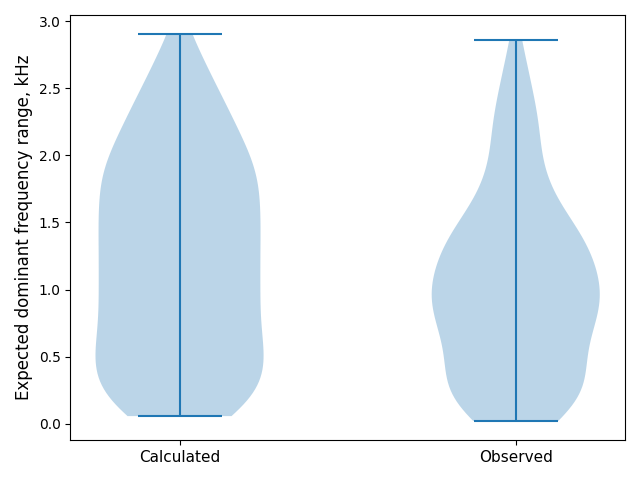

In [156]:
plt.figure()
plt.violinplot([all_diffs,observed_diffs]);
plt.xticks([1,2], ['Calculated', 'Observed'], fontsize=11)
plt.ylabel('Expected dominant frequency range, kHz', fontsize=12)
plt.tight_layout()
plt.savefig('domfreq_range_single.png')

We can see that the calculated dominant frequency difference in a single bat fly-by matches the expected values. The calculated values were generated from realistic parameters based on the dataset itself, with flight speeds between 1.5-3.5 m/s, and acoustic foveas ranging between 100-110 kHz. 

In [80]:
def extract_largest_intrawindow_difference(df):
    '''
    Outputs the largest difference between measurements within one segment in a file. 
    The input datframe is expected to contain measurements from one segment of one file only. 
    
    Parameters
    ----------
    df : pd.DataFrame 
        With compulsory columns: value, measurement, file_name
    Return
    ------
    maxintrawindow_range : pd.DataFrame
        With columns : file_value_range, measurement, segment_number, file_name, num_bats, groupsize
        
    Notes
    -----
    If a file only has one segment and there is only one measured value - a np.nan 
    is returned in the 'file_value_range'
    '''
    
    intra_window_diffs = []
    
    by_segnum = df.groupby(['segment_number'])
    for segnum, subdf in by_segnum:
        if len(subdf['value'])>1:
            range_value = np.nanmax(df['value']) - np.nanmin(df['value'])
        else: 
            range_value = np.nan
        intra_window_diffs.append(range_value)
        
    
    maxintrawindow_range = pd.DataFrame(data={'intrawindow_range': [np.max(intra_window_diffs)]})

    for each in ['measurement','file_name','num_bats','groupsize','segment_number']:
        maxintrawindow_range.loc[:,each] = df.loc[df.index[0],each]
    return maxintrawindow_range


In [81]:
obs_intrawinlevel_domfreq_range = obsdomfreq_byfilename.apply(extract_largest_intrawindow_difference)
virt_intrawinlevel_domfreq_range = virtdomfreq_by_filename.apply(extract_largest_intrawindow_difference)
virt_intrawinlevel_domfreq_range['groupsize'] = 'multiple_virtual'

In [82]:
obsvirt_intrawindow_domfreq_range = pd.concat((obs_intrawinlevel_domfreq_range, virt_intrawinlevel_domfreq_range))

<IPython.core.display.Javascript object>


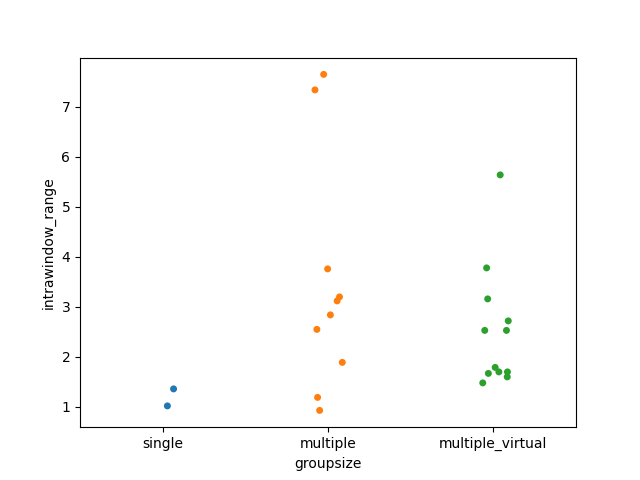

<AxesSubplot:xlabel='groupsize', ylabel='intrawindow_range'>

In [83]:
plt.figure()
sns.stripplot(x='groupsize',y='intrawindow_range',data=obsvirt_intrawindow_domfreq_range)

In [84]:
af = obsvirt_intrawindow_domfreq_range.groupby(['groupsize']).get_group('single')
af[af['intrawindow_range']>0]

,,intrawindow_range,measurement,file_name,num_bats,groupsize,segment_number
file_name,,,,,,,
matching_annotaudio_Aditya_2018-08-19_0120-0200_113_hp.WAV,0,1.02,dominant_frequencies,matching_annotaudio_Aditya_2018-08-19_0120-020...,1,single,6
matching_annotaudio_Aditya_2018-08-19_0120-0200_18_hp.WAV,0,1.36,dominant_frequencies,matching_annotaudio_Aditya_2018-08-19_0120-020...,1,single,0


This sudden drop in the number of data points are because in most windows there is only one dominant frequency. In the few cases where there are multiple dominant frequencies it can clearly be seen that even here, single bat windows have a much lower range than multi bat windows. 

The ~1.5 kHz intra-window difference in single-bat calls is likely due to faint calls from other bats, thought I'm not sure!

In [85]:
obsvirt_reclevel_domfreq_range

,,file_value_range,measurement,file_name,num_bats,groupsize
file_name,,,,,,
matching_annotaudio_Aditya_2018-08-16_21502300_100_hp.WAV,0,0.95,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,1,single
matching_annotaudio_Aditya_2018-08-16_21502300_101_hp.WAV,0,0.87,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,1,single
matching_annotaudio_Aditya_2018-08-16_21502300_102_hp.WAV,0,0.02,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,1,single
matching_annotaudio_Aditya_2018-08-16_21502300_104_hp.WAV,0,1.77,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,1,single
matching_annotaudio_Aditya_2018-08-16_21502300_108_hp.WAV,0,2.49,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,2,multiple
...,...,...,...,...,...,...
matching_annotaudio_Aditya_2018-08-20_0200-0300_66_hp_singlebatmixed.WAV,0,5.12,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0200-030...,2,multiple_virtual
matching_annotaudio_Aditya_2018-08-20_0200-0300_73_hp_singlebatmixed.WAV,0,3.39,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0200-030...,2,multiple_virtual
matching_annotaudio_Aditya_2018-08-20_0200-0300_78_hp_singlebatmixed.WAV,0,2.61,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0200-030...,2,multiple_virtual


### The range difference between interval-separated dominant frequency measurements
Now let's repeat the time-separation exercise now perform *two* comparisons of median difference, multi-single and multi-virtual multi. 

In [86]:
def make_video_annot_id(X):
    return X[20:-7]

def annotation_endtime_failure_tolerant(X):
    try:
        annot_end_time = icf.get_end_time_from_annotation_id([X], video_annotations_folder)[0]
    except:
        annot_end_time =  np.nan
    return annot_end_time

def posix_time_failure_tolerant(X):
    try:
        output =  icf.convert_annotation_time_to_posix(X)
    except:
        output = np.nan
    return output

In [87]:
obsvirt_reclevel_domfreq_range['video_annot_id'] = obsvirt_reclevel_domfreq_range['file_name'].apply(make_video_annot_id)
obsvirt_reclevel_domfreq_range['annotation_end_time'] = obsvirt_reclevel_domfreq_range['video_annot_id'].apply(annotation_endtime_failure_tolerant)
obsvirt_reclevel_domfreq_range['posix_end_time'] = obsvirt_reclevel_domfreq_range['annotation_end_time'].apply(posix_time_failure_tolerant)

In [88]:
def split_into_multisingle_and_multivirtualmulti(obsvirt):
    '''
    Splits a combined dataset with virtual and observed data
    into 2 combinations: multi-single and multi-virtual multi
    
    Parameters
    ----------
    obsvirt : pd.DatFrame
        with columns 'groupsize'
        The 'groupsize' column may not have any entries other than 'single' or 'multiple'
    
    Returns 
    -------
    obs_singlemulti_df, multi_virtmulti_df
    '''
    obs_singlemulti_rows = np.logical_or(obsvirt['groupsize']=='single',
                                    obsvirt['groupsize']=='multiple')
    obs_singlemulti_df = obsvirt[obs_singlemulti_rows].reset_index(drop=True)
    
    
    multi_virtmulti_rows = np.logical_or(obsvirt['groupsize']=='multiple',
                                        obsvirt['groupsize']=='multiple_virtual')
    multi_virtmulti_df = obsvirt[multi_virtmulti_rows].reset_index(drop=True)
    
    
    return obs_singlemulti_df, multi_virtmulti_df


def make_clusteredisolated_folds(all_measurements, clusteredisolated_annotids, w_virtualmulti=False):
    '''
    Parameters
    ----------
    all_measurements : pd.DataFrame
        DataFrame with single and multi bat measurements. 
        The dataframe must contain one column with 'video_annot_id'
    isolatedclustered_annotids : tuple
        Tuple with first entry containing list-like/array of video_annot_id 's 
        of clustered annotations, and the second entry containing that of 
        isolated annotations. 
    w_virtualmulti : boolean
        Defaults to False, and handles the case where all_measurements has multi and single bat data. 
        If True, then it handles the case where all_measurements has multi and virtual-multi bat data. 

    Returns
    -------
    clusteredisolated_datafolds : dictionary
        The key is the intervals, and the entry is a DataFrame.
    '''
    clustered_annotids, isolated_annotids = clusteredisolated_annotids
    if not w_virtualmulti:
        clusteredannots_measurements =  all_measurements[all_measurements['video_annot_id'].isin(clustered_annotids)].reset_index(drop=True)
        isolatedannots_measurements = all_measurements[all_measurements['video_annot_id'].isin(isolated_annotids)].reset_index(drop=True)
    else:
        # separate observed multi and virtual multi
        multirows = all_measurements['groupsize']=='multiple'
        multi_bats = all_measurements[multirows]
        virt_multi = all_measurements[np.invert(multirows)]
        # group isolated and clustered multi bat observations
        isolated_multibats  = multi_bats[multi_bats['video_annot_id'].isin(isolated_annotids)]
        clustered_multibats  = multi_bats[multi_bats['video_annot_id'].isin(clustered_annotids)]

        # combine observed and virtual audio together
        clusteredannots_measurements = pd.concat((clustered_multibats, virt_multi))
        isolatedannots_measurements = pd.concat((isolated_multibats, virt_multi))

    clusteredisolated_datafolds = {}
    clusteredisolated_datafolds['clustered'] = clusteredannots_measurements
    clusteredisolated_datafolds['isolated'] = isolatedannots_measurements
    return clusteredisolated_datafolds

def make_multivirtualmulti_interval_datafolds(multivirtmulti, intervals, N_runs):
    '''
    The challenge here is that the virtual multi audio doesn't have a time stamp associated with it. 
    We will do the following. 
    Generate time-interval separated multiple bat annotation folds. For each fold, we will associate 
    a randomly chosen set of virtual audio measurements that match the sample size of the multi bat 
    data. 
    '''
    only_multi = multivirtmulti[multivirtmulti['groupsize']=='multiple'].reset_index(drop=True)
    only_multi_folds = make_singlemulti_interval_datafolds(only_multi, intervals, N_runs)
    only_virtual = multivirtmulti[multivirtmulti['groupsize']=='multiple_virtual']
    
    multi_virtmulti_folds = {}
    
    for interval, datafolds in only_multi_folds.items():
        multi_virtmulti_folds[interval] = []
        for each in datafolds:
            num_rows  = each.shape[0]
            virtual_subset  = np.random.choice(only_virtual.index, num_rows, replace=False)
            virtual_subset_df = only_virtual.loc[virtual_subset,:]
            multi_virtmulti_folds[interval].append(pd.concat((each,virtual_subset_df)))
    return multi_virtmulti_folds

def get_multiplevirtualmultiple_deltamedians(data_folds, colnames):
    '''
    Parameter
    ---------
    data_folds : list
        List with pd.DataFrames containing the call measurement folds. 
        Each data fold DataFrame must contain the column names in colnames, 
        along with the column 'groupsize'. The groupsize column can have 
        two entries only -  'multiple' and 'virtual_multiple'
    colnames : list
        List with column names that are to be used. 
        
    Returns
    -------
    
    '''
    delta_median = {str(each):[] for each in colnames}
    for column in colnames:
        for each in data_folds:
            by_groupsize = each.groupby('groupsize')
            multi = by_groupsize.get_group('multiple')
            virtmulti = by_groupsize.get_group('multiple_virtual')

            delta_median[column].append(np.nanmedian(multi[column])-np.nanmedian(virtmulti[column]))
    return delta_median


     
def get_multivirtmulti_95pctile_deltamedians(data_folds, colnames):
    '''
    Returns the 95%ile of the delta median for each column, and the number of folds 
    used to calculate the percentile interval.
    '''
    deltamedian_95pctile = {}
    
    delta_medians = get_multiplevirtualmultiple_deltamedians(data_folds, colnames)
    # get 95%ile for each parameters
    
    for colname, data_values in delta_medians.items():
        deltamedian_95pctile[colname] = np.nanpercentile(data_values, [2.5,50,97.5])
    deltamedian_95pctile['num_folds'] = np.tile(len(data_folds),3)
    return deltamedian_95pctile


def get_multisingle_95pctile_deltamedians(data_folds, colnames):
    '''
    Returns the 95%ile of the delta median for each column, and the number of folds 
    used to calculate the percentile interval.
    '''
    deltamedian_95pctile = {}
    
    get_deltamed_and_ci_for_onefold(on)
    # get 95%ile for each parameters
    
    for colname, data_values in delta_medians.items():
        deltamedian_95pctile[colname] = np.nanpercentile(data_values, [2.5,50,97.5])
    deltamedian_95pctile['num_folds'] = np.tile(len(data_folds),3)
    return deltamedian_95pctile


def produce_95ci_df(singlemulti_datafolds, multivirtmulti_datafolds, colnames, intervals):
    multvirtmulti_95ci = []
    singlemulti_95ci = []

    for sep in intervals:
        multivirtmulti_out = get_multivirtmulti_95pctile_deltamedians(multivirtmulti_datafolds[sep],
                                                                          colnames)
        multivirtmulti_out['interval'] = np.tile(sep,3)
        multvirtmulti_95ci.append(pd.DataFrame(data=multivirtmulti_out))

        singlemulti_out = get_multisingle_95pctile_deltamedians(singlemulti_datafolds[sep],
                                                                          colnames)
        singlemulti_out['interval'] = np.tile(sep,3)
        singlemulti_95ci.append(pd.DataFrame(data=singlemulti_out))
    return pd.concat(singlemulti_95ci), pd.concat(multvirtmulti_95ci)


def range_difference_permutation_test():
    '''
    '''

In [89]:
obs_singlemulti_domfreq, multivirtmulti_domfreq = split_into_multisingle_and_multivirtualmulti(obsvirt_reclevel_domfreq_range)

In [146]:
obs_singlemulti_domfreq.to_csv('obs_singlemulti_domfreq.csv')
multivirtmulti_domfreq.to_csv('multivirtmulti_domfreq.csv')

In [90]:
clusteredisolated_videoannots = [windowanalysis_clustered_datafold['video_annot_id'],windowanalysis_isolated_datafold['video_annot_id']]

In [91]:
clusteredisolated_singlemulti_domfreqs = make_clusteredisolated_folds(obs_singlemulti_domfreq, clusteredisolated_videoannots)
clusteredisolated_multivirtmutli_domfreqs = make_clusteredisolated_folds(multivirtmulti_domfreq, clusteredisolated_videoannots,
                                                                        w_virtualmulti=True)

In [92]:
clust, isol = clusteredisolated_videoannots

In [93]:
mdomfreq = multivirtmulti_domfreq[multivirtmulti_domfreq['groupsize']=='multiple']
mdomfreq[mdomfreq['video_annot_id'].isin(isol)]


,file_value_range,measurement,file_name,num_bats,groupsize,video_annot_id,annotation_end_time,posix_end_time
27,2.02,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_01_24_hp...,2,multiple,Aditya_2018-08-17_01_24,NaN,NaN
36,5.17,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_23_157_h...,2,multiple,Aditya_2018-08-17_23_157,NaN,NaN
40,3.96,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_23_196_h...,2,multiple,Aditya_2018-08-17_23_196,NaN,NaN
57,2.87,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_34_72_hp...,2,multiple,Aditya_2018-08-17_34_72,NaN,NaN
62,0.24,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_45_135_h...,2,multiple,Aditya_2018-08-17_45_135,NaN,NaN
68,1.36,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_56_58_hp...,3,multiple,Aditya_2018-08-17_56_58,NaN,NaN
82,2.46,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0200-030...,2,multiple,Aditya_2018-08-20_0200-0300_43,NaN,NaN
85,3.08,dominant_frequencies,matching_annotaudio_Aditya_2018-08-20_0200-030...,2,multiple,Aditya_2018-08-20_0200-0300_78,NaN,NaN


Now, in general we see that multi bat audio has an overall increased bandwidth of ~3 kHz in comparison to single bat bandwidth. An overall increase is expected just because there are multiple calls, but how much is explained ?

Let's simulate a situation where pairs of bats with different Fe's and flight speeds fly together and estimate what the bandiwidth is expected to be.

In [94]:
# store the max-min difference resulting from each param combination 

maxmin_diff = {each: [] for each in ['v_start','v_end','Fo','diff','frec_start','frec_end']}

for one_fo in Fo:
    for one_vstart in v_start:
        for one_vend in v_end:
            diff, details = calc_frec_difference(one_fo, one_vstart, one_vend)
            maxmin_diff['diff'].append(diff*0.001)
            maxmin_diff['v_start'].append(one_vstart)
            maxmin_diff['v_end'].append(one_vend)
            maxmin_diff['Fo'].append(one_fo*0.001)
            maxmin_diff['frec_start'].append(details['frec_start'])
            maxmin_diff['frec_end'].append(details['frec_end'])

# convert to kHz
diff_param_combis = pd.DataFrame(data=maxmin_diff)

Now let's simulate the expected min-max difference when 2 bats with different Fo's are randomly chosen with different flight speeds. 

In [95]:
def simulate_2bats_freq_diff_at_mic(df):
    by_fo = df.groupby('Fo')
    # choose two Fo's to represent 2 bats
    two_Fos = np.random.choice(list(by_fo.groups.keys()),2, replace=False)
    two_Fo_dfs = [ by_fo.get_group(each) for each in two_Fos]
    
    random_rows = [ int(np.random.choice(each_fo.index,1))  for each_fo in two_Fo_dfs]
    frecs = pd.concat([ df.loc[row_num,:]  for row_num, df in zip(random_rows, two_Fo_dfs)],1).T
    
    only_freqs = frecs.loc[:,['frec_start','frec_end']].to_numpy().flatten() #.to_list()
    overall_diff = np.max(only_freqs)-np.min(only_freqs)
    
    return frecs, overall_diff*0.001
    

In [96]:
sim_multibat_domfreq_diff = []
for each in range(1000):
    _,b = simulate_2bats_freq_diff_at_mic(diff_param_combis)
    sim_multibat_domfreq_diff.append(b)


In [97]:
# save all the lists into a nice dataframe for the plotting notebook 
all_values = (observed_diffs,all_diffs,sim_multibat_domfreq_diff)
domfreq_ranges = {}

domfreq_ranges['domfreq_range'] = np.concatenate(all_values)
domfreq_ranges['source'] = np.concatenate([np.tile(name,len(each)) for name,each in zip(['observed','sim_single','sim_multi'],all_values)])
domfreq_ranges = pd.DataFrame(data=domfreq_ranges)
domfreq_ranges.to_csv('domfreqranges_calculated_simulated.csv')

<IPython.core.display.Javascript object>


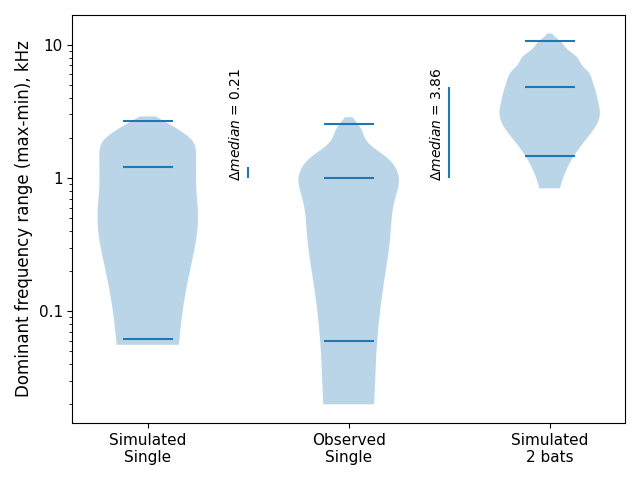

In [157]:
plt.figure()
#plt.violinplot(overall_freq_diff)
plt.violinplot([all_diffs,observed_diffs,sim_multibat_domfreq_diff], showextrema=False,
              quantiles=[[0.025,0.5,0.975] for i in range(3)]);
plt.yscale(u'log')
plt.xticks([1,2,3],['Simulated\nSingle','Observed\nSingle','Simulated\n2 bats'], fontsize=11)
plt.ylabel('Dominant frequency range (max-min), kHz', fontsize=12)
plt.yticks([0.1,1,10],[0.1,1,10], fontsize=11)
# now make the delta medians
obs_sim_singlebat = np.sort([np.median(each) for each in [observed_diffs,sim_multibat_domfreq_diff]])
obs_sim_low, obs_sim_hight = obs_sim_singlebat
median_diff_obs_multisim = '$\Delta median$ = ' f'{float(np.diff(obs_sim_singlebat)):.2f}' 
plt.vlines(2.5,obs_sim_low, obs_sim_hight);
plt.text(2.4,obs_sim_low,median_diff_obs_multisim, rotation=90)

# 
obs_sim_singlebat = np.sort([np.median(each) for each in [observed_diffs,all_diffs]])
obs_sim_low, obs_sim_hight = obs_sim_singlebat
median_diff_obs_multisim = '$\Delta median$ = ' f'{float(np.diff(obs_sim_singlebat)):.2f}' 
plt.vlines(1.5,obs_sim_low, obs_sim_hight);
plt.text(1.4,obs_sim_low,median_diff_obs_multisim, rotation=90)

plt.tight_layout()
plt.savefig('domfreqrange_singlemultisim.png')

### Dominant frequency range difference
Let us compare the single-multi and multi-virtual range difference for the entire dataset, and then repeat the analysis for clustered and isolated subsets. 

In [99]:
# function which calculates the multi-single and multi-virtmulti median difference in domfreq range 
def calculate_mediandiff_in_domfreqrange(obs_singlemulti, multivirtmulti):
    # multi - single median difference in dom freq range
    mediandiff_domfreq_singlemulti = process_for_testing(obs_singlemulti,'file_value_range').median_diff
    singlemulti_domfreq_results = mediandiff_domfreq_singlemulti.results.loc[:,['difference','pvalue_permutation']]
    singlemulti_domfreq_results['comparison'] = 'singlemulti'
    # multi - single median difference in dom freq range
    mediandiff_domfreq_multivirtmulti = process_for_testing(multivirtmulti,'file_value_range',
                                                            idx=['multiple_virtual','multiple']).median_diff
    multivirtmulti_domfreq_results = mediandiff_domfreq_multivirtmulti.results.loc[:,['difference','pvalue_permutation']]
    multivirtmulti_domfreq_results['comparison'] = 'multivirtmulti'

    # summarise results in one DF
    all_domfreq_results = pd.concat((singlemulti_domfreq_results,
                                    multivirtmulti_domfreq_results)).reset_index(drop=True)
    return all_domfreq_results

#### Whole data set analysis 

In [100]:
wholedataset_domfreqrange = calculate_mediandiff_in_domfreqrange(obs_singlemulti_domfreq,multivirtmulti_domfreq)
wholedataset_domfreqrange['analysis_level'] = 'complete'
wholedataset_domfreqrange

,difference,pvalue_permutation,comparison,analysis_level
0,2.20,0.0000,singlemulti,complete
1,0.48,0.1564,multivirtmulti,complete


#### Clustered dominant frequency range analysis 

In [101]:
clustereddataset_domfreqrange = calculate_mediandiff_in_domfreqrange(clusteredisolated_singlemulti_domfreqs['clustered'],
                                                                     clusteredisolated_multivirtmutli_domfreqs['clustered'])
clustereddataset_domfreqrange['analysis_level'] = 'clustered'
clustereddataset_domfreqrange

,difference,pvalue_permutation,comparison,analysis_level
0,2.38,0.0000,singlemulti,clustered
1,0.66,0.0876,multivirtmulti,clustered


In [149]:
clusteredisolated_singlemulti_domfreqs['clustered'].to_csv('clust_domfreq_singlemulti.csv')
clusteredisolated_singlemulti_domfreqs['isolated'].to_csv('isolated_domfreq_singlemulti.csv')

In [151]:
clusteredisolated_multivirtmutli_domfreqs['clustered'].to_csv('clust_domfreq_multivirt.csv')
clusteredisolated_multivirtmutli_domfreqs['isolated'].to_csv('isolated_domfreq_multivirt.csv')

In [102]:
isolateddataset_domfreqrange = calculate_mediandiff_in_domfreqrange(clusteredisolated_singlemulti_domfreqs['isolated'],
                                                                     clusteredisolated_multivirtmutli_domfreqs['isolated'])
isolateddataset_domfreqrange['analysis_level'] = 'isolated'
isolateddataset_domfreqrange

,difference,pvalue_permutation,comparison,analysis_level
0,1.665,0.0000,singlemulti,isolated
1,-0.055,0.9504,multivirtmulti,isolated


In [103]:
dominant_freqrange_analysis = pd.concat((wholedataset_domfreqrange,
                                         clustereddataset_domfreqrange,
                                         isolateddataset_domfreqrange))
dominant_freqrange_analysis.to_csv('domfreq_results_all.csv')

<a id='receivedlevel'></a>
### Received level comparisons

Here we will *estimate* the median difference in window received levels across group-types. We will not be performing any statistical tests on these estimations. 

In [104]:
obs_rms = obs_splitmeasure[obs_splitmeasure['measurement']=='rms']
virt_rms = virt_splitmeasure[virt_splitmeasure['measurement']=='rms']

obsvirt_rms = pd.concat([obs_rms, virt_rms])
obsvirt_dbrms = obsvirt_rms.copy()
obsvirt_dbrms['value'] = dB(obsvirt_dbrms['value'])

In [105]:
obsvirt_dbrms['video_annot_id'] = obsvirt_dbrms['file_name'].apply(make_video_annot_id)

In [106]:
obs_singlemulti_dbrms, multivirtmulti_dbrms = split_into_multisingle_and_multivirtualmulti(obsvirt_dbrms)

In [107]:
obs_singlemulti_dbrms.to_csv('obs_singlemulti_dbrms.csv')
multivirtmulti_dbrms.to_csv('multivirtmulti_dbrms.csv')

In [110]:
def estimate_median_difference_windowanalysis(df, num_runs=5000):
    '''
    Repeatedly chooses one value from one window of each file 
    and calculates the median-difference between either multi-single 
    or multi-virtual multi. 
    '''
    # split into multiple and non-multiple groupsizes
    by_groupsize = df.groupby('groupsize')
    other_group = list(set(by_groupsize.groups.keys())-set(['multiple']))[0]
    
    multiple_all = by_groupsize.get_group('multiple')
    other_all = by_groupsize.get_group(other_group)

    # repeatedly choose one value per window per file and calculate multi-other median difference
    median_differences = Parallel(n_jobs=4)(delayed(calculate_one_median_difference)(multiple_all, other_all, 'value')for each in tqdm.tqdm(range(num_runs)))
    return median_differences

def calculate_one_median_difference(multi_all, nonmulti_all,colname):
    multi_values = extract_one_value_per_file(multi_all, colname)
    other_values = extract_one_value_per_file(nonmulti_all, colname)
    return np.nanmedian(multi_values)-np.nanmedian(other_values)

def extract_one_value_per_file(df,colname):
    '''
   
    Parameters
    ----------
    df : pd.DataFrame 
        With compulsory columns: value, measurement, file_name
    Return
    ------
    maxintrawindow_range : pd.DataFrame
        With columns : file_value_range, measurement, segment_number, file_name, num_bats, groupsize
        
    Notes
    -----
    If a file only has one segment and there is only one measured value - a np.nan 
    is returned in the 'file_value_range'
    '''
    by_filename = df.groupby('file_name')
    one_value_per_file = by_filename.apply(choose_one_value, colname=colname)
    return one_value_per_file

def choose_one_value(subdf, colname):
    all_values = subdf[colname]
    return np.random.choice(all_values,1)[0]


In [111]:
singlemulti_dbrms_meddiff = estimate_median_difference_windowanalysis(obs_singlemulti_dbrms)
multivirtmulti_dbrms_meddiff = estimate_median_difference_windowanalysis(multivirtmulti_dbrms)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 90.60it/s]


In [112]:
print(f'The Multi-Single 95%ile range for median rec. level difference is: {np.percentile(singlemulti_dbrms_meddiff,[2.5,97.5])}')
print(f'The Multi-Virtual multi 95%ile range for median rec. level difference is: {np.percentile(multivirtmulti_dbrms_meddiff,[2.5,97.5])}')

The Multi-Single 95%ile range for median rec. level difference is: [-0.87556463  1.61006972]
The Multi-Virtual multi 95%ile range for median rec. level difference is: [-0.72105998  2.09523375]


Now, let us take a look at the median difference range in the clustered and isolated subsets

In [113]:
clusteredisolated_singlemulti_dbrms = make_clusteredisolated_folds(obs_singlemulti_dbrms, clusteredisolated_videoannots)
clusteredisolated_multivirtmutli_dbrms = make_clusteredisolated_folds(multivirtmulti_dbrms, clusteredisolated_videoannots,
                                                                        w_virtualmulti=True)

In [114]:
singlemulti_clustered_dbrms_meddiff = estimate_median_difference_windowanalysis(clusteredisolated_singlemulti_dbrms['clustered'])
multivirtmulti_clustered_dbrms_meddiff = estimate_median_difference_windowanalysis(clusteredisolated_multivirtmutli_dbrms['clustered'])

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:51<00:00, 96.52it/s]


In [115]:
print(f'The Multi-Single 95%ile range for median rec. level difference is: {np.percentile(singlemulti_clustered_dbrms_meddiff,[2.5,97.5])}')
print(f'The Multi-Virtual multi 95%ile range for median rec. level difference is: {np.percentile(multivirtmulti_clustered_dbrms_meddiff,[2.5,97.5])}')

The Multi-Single 95%ile range for median rec. level difference is: [-1.19937297  1.51640473]
The Multi-Virtual multi 95%ile range for median rec. level difference is: [-0.77131604  2.27955862]


In [116]:
singlemulti_isolated_dbrms_meddiff = estimate_median_difference_windowanalysis(clusteredisolated_singlemulti_dbrms['isolated'])
multivirtmulti_isolated_dbrms_meddiff = estimate_median_difference_windowanalysis(clusteredisolated_multivirtmutli_dbrms['isolated'])

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 160.20it/s]


In [117]:
print(f'The Multi-Single 95%ile range for median rec. level difference is: {np.percentile(singlemulti_isolated_dbrms_meddiff,[2.5,97.5])}')
print(f'The Multi-Virtual multi 95%ile range for median rec. level difference is: {np.percentile(multivirtmulti_isolated_dbrms_meddiff,[2.5,97.5])}')

The Multi-Single 95%ile range for median rec. level difference is: [-1.87978381  3.28521413]
The Multi-Virtual multi 95%ile range for median rec. level difference is: [-2.22749343  2.88639115]


In [118]:
# Put together all the results in one place 
all_meddifs = [singlemulti_dbrms_meddiff,
               multivirtmulti_dbrms_meddiff,
               singlemulti_clustered_dbrms_meddiff,
               multivirtmulti_clustered_dbrms_meddiff,
               singlemulti_isolated_dbrms_meddiff,
               multivirtmulti_isolated_dbrms_meddiff]
lower_pctile_dbrms = [np.percentile(each,2.5) for each in all_meddifs]
upper_pctile_dbrms = [np.percentile(each,97.5) for each in all_meddifs]

estim_dbrms_diff = pd.DataFrame(data={'estimated_diff_2.5pctile':lower_pctile_dbrms,
                                      'estimated_diff_97.5pctile':upper_pctile_dbrms,
                                      'data_type':['all','all',
                                                   'clustered','clustered',
                                                   'isolated','isolated']})
estim_dbrms_diff['median_diff_measurement'] = 'dbrms'
estim_dbrms_diff['comparison'] = np.tile(['multi-single','multi-virtual multi'],3)
estim_dbrms_diff

,estimated_diff_2.5pctile,estimated_diff_97.5pctile,data_type,median_diff_measurement,comparison
0,-0.875565,1.610070,all,dbrms,multi-single
1,-0.721060,2.095234,all,dbrms,multi-virtual multi
2,-1.199373,1.516405,clustered,dbrms,multi-single
3,-0.771316,2.279559,clustered,dbrms,multi-virtual multi
4,-1.879784,3.285214,isolated,dbrms,multi-single
5,-2.227493,2.886391,isolated,dbrms,multi-virtual multi


In [119]:
obs_termfreq = obs_splitmeasure[obs_splitmeasure['measurement']=='fm_terminal_freqs']
virt_termfreq = virt_splitmeasure[virt_splitmeasure['measurement']=='fm_terminal_freqs']

obsvirt_termfreq = pd.concat([obs_termfreq, virt_termfreq])
obsvirt_termfreq = obsvirt_termfreq.copy()
obsvirt_termfreq['value'] = (obsvirt_termfreq['value'])

In [120]:
obsvirt_termfreq['value']*=0.001

In [121]:
obsvirt_termfreq

,Unnamed: 0,Unnamed: 0.1,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,groupsize
2,2,3,90.332031,0,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
3,3,4,89.843750,0,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
6,6,8,91.796875,1,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-16_21502300...,1_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
7,7,9,90.820312,1,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-16_21502300...,1_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
10,10,14,90.820312,4,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-16_21502300...,4_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_100,1,single
...,...,...,...,...,...,...,...,...,...,...
3170,3170,4895,95.703125,102,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-20_0200-030...,102_matching_annotaudio_Aditya_2018-08-20_0200...,Aditya_2018-08-20_0200-0300_92,2,multiple_virtual
3173,3173,4900,NaN,103,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-20_0200-030...,103_matching_annotaudio_Aditya_2018-08-20_0200...,Aditya_2018-08-20_0200-0300_92,2,multiple_virtual
3176,3176,4904,NaN,104,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-20_0200-030...,104_matching_annotaudio_Aditya_2018-08-20_0200...,Aditya_2018-08-20_0200-0300_92,2,multiple_virtual
3179,3179,4910,NaN,105,fm_terminal_freqs,matching_annotaudio_Aditya_2018-08-20_0200-030...,105_matching_annotaudio_Aditya_2018-08-20_0200...,Aditya_2018-08-20_0200-0300_92,2,multiple_virtual


In [122]:
obsvirt_termfreq['video_annot_id'] = obsvirt_termfreq['file_name'].apply(make_video_annot_id)

In [123]:
obs_singlemulti_termfreq, multivirtmulti_termfreq = split_into_multisingle_and_multivirtualmulti(obsvirt_termfreq)

In [124]:
# all data
singlemulti_termfreq_meddiff = estimate_median_difference_windowanalysis(obs_singlemulti_termfreq)
multivirtmulti_termfreq_meddiff = estimate_median_difference_windowanalysis(multivirtmulti_termfreq)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 88.25it/s]


In [125]:
print(f'The Multi-Single 95%ile range for median rec. level difference is: {np.percentile(singlemulti_termfreq_meddiff,[2.5,97.5])}')
print(f'The Multi-Virtual multi 95%ile range for median rec. level difference is: {np.percentile(multivirtmulti_termfreq_meddiff,[2.5,97.5])}')

The Multi-Single 95%ile range for median rec. level difference is: [-1.46484375  0.9765625 ]
The Multi-Virtual multi 95%ile range for median rec. level difference is: [-1.953125   0.9765625]


Now, let us take a look at the median difference range in the clustered and isolated subsets

In [126]:
clusteredisolated_singlemulti_termfreq = make_clusteredisolated_folds(obs_singlemulti_termfreq, clusteredisolated_videoannots)
clusteredisolated_multivirtmutli_termfreq = make_clusteredisolated_folds(multivirtmulti_termfreq, clusteredisolated_videoannots,
                                                                        w_virtualmulti=True)

In [127]:
singlemulti_clustered_termfreq_meddiff = estimate_median_difference_windowanalysis(clusteredisolated_singlemulti_termfreq['clustered'])
multivirtmulti_clustered_termfreq_meddiff = estimate_median_difference_windowanalysis(clusteredisolated_multivirtmutli_termfreq['clustered'])

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:54<00:00, 92.45it/s]


In [128]:
print(f'The Multi-Single 95%ile range for median rec. level difference is: {np.percentile(singlemulti_clustered_termfreq_meddiff,[2.5,97.5])}')
print(f'The Multi-Virtual multi 95%ile range for median rec. level difference is: {np.percentile(multivirtmulti_clustered_termfreq_meddiff,[2.5,97.5])}')

The Multi-Single 95%ile range for median rec. level difference is: [-0.9765625   1.46484375]
The Multi-Virtual multi 95%ile range for median rec. level difference is: [-1.953125   0.9765625]


In [129]:
singlemulti_isolated_termfreq_meddiff = estimate_median_difference_windowanalysis(clusteredisolated_singlemulti_termfreq['isolated'])
multivirtmulti_isolated_termfreq_meddiff = estimate_median_difference_windowanalysis(clusteredisolated_multivirtmutli_termfreq['isolated'])

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:32<00:00, 156.09it/s]


In [130]:
print(f'The Multi-Single 95%ile range for median rec. level difference is: {np.percentile(singlemulti_isolated_termfreq_meddiff,[2.5,97.5])}')
print(f'The Multi-Virtual multi 95%ile range for median rec. level difference is: {np.percentile(multivirtmulti_isolated_termfreq_meddiff,[2.5,97.5])}')

The Multi-Single 95%ile range for median rec. level difference is: [-4.15039062  1.70898438]
The Multi-Virtual multi 95%ile range for median rec. level difference is: [-4.15039062  1.953125  ]


In [131]:
# Put together all the results in one place 
all_termfreq_meddifs = [singlemulti_clustered_termfreq_meddiff,
               multivirtmulti_termfreq_meddiff,
               singlemulti_clustered_termfreq_meddiff,
               multivirtmulti_clustered_termfreq_meddiff,
               singlemulti_isolated_termfreq_meddiff,
               multivirtmulti_isolated_termfreq_meddiff]
lower_pctile_termfreq = [np.percentile(each,2.5) for each in all_termfreq_meddifs]
upper_pctile_termfreq = [np.percentile(each,97.5) for each in all_termfreq_meddifs]

estim_termfreq_diff = pd.DataFrame(data={'estimated_diff_2.5pctile':lower_pctile_termfreq,
                                      'estimated_diff_97.5pctile':upper_pctile_termfreq,
                                      'data_type':['all','all',
                                                   'clustered','clustered',
                                                   'isolated','isolated']})
estim_termfreq_diff['median_diff_measurement'] = 'termfreq'
estim_termfreq_diff['comparison'] = np.tile(['multi-single','multi-virtual multi'],3)

estim_termfreq_diff

,estimated_diff_2.5pctile,estimated_diff_97.5pctile,data_type,median_diff_measurement,comparison
0,-0.976562,1.464844,all,termfreq,multi-single
1,-1.953125,0.976562,all,termfreq,multi-virtual multi
2,-0.976562,1.464844,clustered,termfreq,multi-single
3,-1.953125,0.976562,clustered,termfreq,multi-virtual multi
4,-4.150391,1.708984,isolated,termfreq,multi-single
5,-4.150391,1.953125,isolated,termfreq,multi-virtual multi


In [132]:
recleveltermfreq_estimations = pd.concat((estim_termfreq_diff, estim_dbrms_diff))
recleveltermfreq_estimations

,estimated_diff_2.5pctile,estimated_diff_97.5pctile,data_type,median_diff_measurement,comparison
0,-0.976562,1.464844,all,termfreq,multi-single
1,-1.953125,0.976562,all,termfreq,multi-virtual multi
2,-0.976562,1.464844,clustered,termfreq,multi-single
3,-1.953125,0.976562,clustered,termfreq,multi-virtual multi
4,-4.150391,1.708984,isolated,termfreq,multi-single
5,-4.150391,1.953125,isolated,termfreq,multi-virtual multi
0,-0.875565,1.610070,all,dbrms,multi-single
1,-0.721060,2.095234,all,dbrms,multi-virtual multi
2,-1.199373,1.516405,clustered,dbrms,multi-single
3,-0.771316,2.279559,clustered,dbrms,multi-virtual multi


In [133]:
def create_windowanalysis_summary_table(dataset_domfreqrange, singlemulti_dbrms_deltamed,
                                         multivirtmulti_dbrms_deltamed,
                                          singlemulti_termfreq_deltamed,
                                        multivirtmulti_termfreq_deltamed):
    '''
    singlemulti_results,multivirtmulti_results : [reclevel, termfreq]
    '''
    # window whole data results 
    singlemulti_reclevel_25,singlemulti_reclevel_975 = np.round(np.percentile(singlemulti_dbrms_deltamed,[2.5, 97.5]),2)
    multivirt_reclevel_25, multivirt_reclevel_975 = np.round(np.percentile(multivirtmulti_dbrms_deltamed, [2.5,97.5]),2)

    singlemulti_tf_25,singlemulti_tf_975 = np.round(np.percentile(singlemulti_termfreq_deltamed,[2.5,97.5]),2)
    multivirt_tf_25,multivirt_tf_975 = np.round(np.percentile(multivirtmulti_termfreq_deltamed,[2.5,97.5]),2)


    param_names = ['Dominant frequency range (kHz)',
                   'Received level (dB rms)',
                   'Terminal FM frequency (kHz)']
    window_analysis_df_singlemulti = pd.DataFrame(data={'Parameter' :param_names,
                                                         'Median difference': [dataset_domfreqrange['difference'][0],
                                                                               np.nan,np.nan],
                                                        'Permutation-test p':[ dataset_domfreqrange['pvalue_permutation'][0],
                                                                              np.nan,np.nan],
                                                        'Median difference (2.5 %ile)'  :[np.nan,
                                                                                          singlemulti_reclevel_25
                                                                                          ,singlemulti_tf_25],
                                                        'Median difference (97.5 %ile)' :[np.nan,
                                                                                          singlemulti_reclevel_975,
                                                                                          singlemulti_tf_975]})

    window_analysis_df_multivirt = pd.DataFrame(data={'Parameter' :param_names,
                                                       'Median difference': [dataset_domfreqrange['difference'][1],
                                                                               np.nan,np.nan],
                                                        'Permutation-test p':[ dataset_domfreqrange['pvalue_permutation'][1],
                                                                              np.nan,np.nan],
                                                        'Median difference (2.5 %ile)'  :[np.nan ,
                                                                                          multivirt_reclevel_25,
                                                                                         multivirt_tf_25],
                                                        'Median difference (97.5 %ile)' :[np.nan,
                                                                                          multivirt_reclevel_975
                                                                                          ,multivirt_tf_975]})
    window_analysis_df_singlemulti['comparison'] = 'multi-single'
    window_analysis_df_multivirt['comparison'] = 'multi-virtual multi'
    
    return pd.concat([window_analysis_df_singlemulti,window_analysis_df_multivirt]).reset_index(drop=True)

In [134]:
whole_window_summary= create_windowanalysis_summary_table(wholedataset_domfreqrange, 
                                                                                     singlemulti_dbrms_meddiff,
                                                                                     multivirtmulti_dbrms_meddiff,
                                                                                     singlemulti_termfreq_meddiff,
                                                                                     multivirtmulti_termfreq_meddiff)
whole_window_summary.to_csv('whole_window_summary.csv')
whole_window_summary

,Parameter,Median difference,Permutation-test p,Median difference (2.5 %ile),Median difference (97.5 %ile),comparison
0,Dominant frequency range (kHz),2.20,0.0000,NaN,NaN,multi-single
1,Received level (dB rms),NaN,NaN,-0.88,1.61,multi-single
2,Terminal FM frequency (kHz),NaN,NaN,-1.46,0.98,multi-single
3,Dominant frequency range (kHz),0.48,0.1564,NaN,NaN,multi-virtual multi
4,Received level (dB rms),NaN,NaN,-0.72,2.10,multi-virtual multi
5,Terminal FM frequency (kHz),NaN,NaN,-1.95,0.98,multi-virtual multi


In [135]:
clustered_window_summary = create_windowanalysis_summary_table(clustereddataset_domfreqrange,
                                                                                singlemulti_clustered_dbrms_meddiff,
                                                                                multivirtmulti_clustered_dbrms_meddiff,
                                                                                singlemulti_clustered_termfreq_meddiff,
                                                                                multivirtmulti_clustered_termfreq_meddiff)
clustered_window_summary.to_csv('clustered_window_summary.csv')
clustered_window_summary

,Parameter,Median difference,Permutation-test p,Median difference (2.5 %ile),Median difference (97.5 %ile),comparison
0,Dominant frequency range (kHz),2.38,0.0000,NaN,NaN,multi-single
1,Received level (dB rms),NaN,NaN,-1.20,1.52,multi-single
2,Terminal FM frequency (kHz),NaN,NaN,-0.98,1.46,multi-single
3,Dominant frequency range (kHz),0.66,0.0876,NaN,NaN,multi-virtual multi
4,Received level (dB rms),NaN,NaN,-0.77,2.28,multi-virtual multi
5,Terminal FM frequency (kHz),NaN,NaN,-1.95,0.98,multi-virtual multi


In [136]:
isolated_window_summary = create_windowanalysis_summary_table(isolateddataset_domfreqrange,
                                                            singlemulti_isolated_dbrms_meddiff,
                                                            multivirtmulti_isolated_dbrms_meddiff,
                                                            singlemulti_isolated_termfreq_meddiff,
                                                            multivirtmulti_isolated_termfreq_meddiff)
isolated_window_summary.to_csv('isolated_window_summary.csv')
isolated_window_summary

,Parameter,Median difference,Permutation-test p,Median difference (2.5 %ile),Median difference (97.5 %ile),comparison
0,Dominant frequency range (kHz),1.665,0.0000,NaN,NaN,multi-single
1,Received level (dB rms),NaN,NaN,-1.88,3.29,multi-single
2,Terminal FM frequency (kHz),NaN,NaN,-4.15,1.71,multi-single
3,Dominant frequency range (kHz),-0.055,0.9504,NaN,NaN,multi-virtual multi
4,Received level (dB rms),NaN,NaN,-2.23,2.89,multi-virtual multi
5,Terminal FM frequency (kHz),NaN,NaN,-4.15,1.95,multi-virtual multi
